# EXPERIMENTO - ENFOQUES TRADICIONALES: SVM - LR
Encontrar los mejores modelos tradicionales para los dataset propuestos. 
Para ello se realiza la ejecución (Búsqueda GridSeach + Evaluación) de cada dataset a fuerza bruta, es decir haciendo todas las combinaciones de:
- Tipos de Preprocesamiento: 
  - Baseline
  - Baseline sin stopwords 
  - Baseline con stopwords 
  - Preprocesamiento 
  - Procesamiento sin stopwords 
  - Procesamiento con stopwords
- Tipos de Representaciones de Textos
  - BoW
  - BoW (tf-idf)
  - 3,4-Gramas de Caracteres (tf-idf)
  - 1,2-Gramas de Palabras (tf-idf)
- Tipos de Clasificadores
  - SVM (Support Vector Machines)
  - LR (Logistic Regression)

  Los resultados de todas las combinaciones serán guardados en un archivo .csv

## Librerías necesarias

In [ ]:
import re
import pandas as pd
import numpy as np
import unicodedata
from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#PREPROCESAMIENTO USANDO STOPWORDS DE NLTK => 313 PALABRAS
from nltk.tokenize import word_tokenize
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thompson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thompson\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Configuraciones para la Ejecución
Deben efectuarse las siguientes configuraciones:


###1.   Dataset a utilizar: Ubicación y/o nombre de cada archivo
Si trabaja con un único dataset no es necesario especificar TEST_PATH (división train/test sobre un único archivo). 

Luego deberá configurarse la invocación de los datasets en el programa principal. 

Si desea trabajar con más de un dataset deberá crear y referenciar las varibales en el programa principal.


###2.   Hiperparámetros para los modelos
Especificar los hiperparámetros a estudiar para cada uno de los modelos


###3.   Variables de Experimentación
Especificar variables que participarán en la combinatoria de la experimentación.

Variables que estén activadas (True) serán combinadas y evaluadas durante el proceso.

###4.   Resultados y Reportes
Especificar nombre de archivos donde se almacenarán los resultados de la experimentación. Configurar si se desea imprimir la Matriz de Confusión, reportes y preguntas mal clasificadas. 




In [ ]:
#CONFIGURACIONES PARA LA EJECUCIÓN

#--------------------------------------------------------------
#1. Dataset a utilizar: Ubicación y/o nombre de cada archivo
#--------------------------------------------------------------
DS1_PATH = "DS1_usuario_afip.csv"
DS2_PATH = "DS2-train_usuario.csv"
TEST_PATH = "DS2-test_afip.csv"
TEST_SIZE = 0.20 # train:80% - test:20%

#--------------------------------------------------------------
#2. Hiperparámetros para los modelos
#--------------------------------------------------------------
#HIPERPARÁMETROS PARA SVM
HP_SVM_C = [0.001, 0.01, 0.1, 1, 2, 5, 10, 100]
HP_SVM_GAMMA = [0.001, 0.01, 0.1, 1, 10, 100]
HP_SVM_KERNEL = ['rbf', 'sigmoid']

#HIPERPARÁMETROS PARA LogisticRegression
HP_LR_C = [0.001, 0.01, 0.1, 1, 10, 100]



#--------------------------------------------------------------
#3. Variables de Experimentación
#--------------------------------------------------------------

PREPROC_Select = { 
            "BASELINE": True,
            "BASELINE_STOPWORD_SINFILTRO": True,
            "BASELINE_STOPWORD_CONFILTRO": True,
            "PROC" : True,
            "PROC_STOPWORD_CONFILTRO": True,
            "PROC_STOPWORD_SINFILTRO": True
        }

DS_Select = {"DS1" : True,  #DS1: Preguntas Etiquetadas Manualmente + Preguntas Reescritas + Consultas AFIP
             "DS2" : True   #DS2: Preguntas Etiquetadas Manualmente + Preguntas Reescritas
        }

MOD_Select = {"SVM" : True,
              "LR" : True
        }
REPSEN_Select = {"BOW" : True,
        "BOW_TFIDF" : True,
        "3_4G_CHAR" : True,
        "1_2G_WORD" : True
        }


#--------------------------------------------------------------
#4. Resultados y Reportes
#--------------------------------------------------------------

#ALMACENAMIENTO DE RESULTADOS
PRINT_RES = True
DF_RESULTADOS =  pd.DataFrame(columns=["DS","PREPROC", "MOD","acc-train","acc-cv", "acc-test", "best-params","tam-rep"])
FILENAME_RES = "Resultados_2DS_Principal_procTest.csv"

#REGISTRO DE PREGUNTAS MAL CLASIFICADAS
PRINT_MAL_CLF = True
DF_MAL_CLF =  pd.DataFrame(columns=["DS","PREPROC", "MOD", "Texto", "Predicho","Real"])
FILENAME_RES_CLF = "Resultados_2DS_PregMalClasif_procTest.csv"

#REPORTES
MATRIZ_CONFUSION = True
REPORTES = True

## Carga de Datos y Preprocesamiento
Funciones para cargar los datasets y preprocesar los datos. Estas funciones serán invocadas por el programa principal (final de la notebook).

###1.   Funciones de Preprocesamiento de Sentencias

*procesar_sentencias(..)*: Inicia el preprocesamiento e invoca a *corregir_palabras(..)* para efectuar la limpieza de los documentos en funcion a los tipos de preprocesamientos especificados en "Configuraciones para la Ejecución". De allí, se invocan las demás funciones de preprocesamiento.

###2.   Carga de Datos
Permite crear un objeto de tipo "*dataset*" que contendrá la información (Conjuntos Train y Test) del corpus invocado. 

La función *generar_dataset(fileTrainName, fileTestName, modoProcesamiento)* se invoca desde programa principal y permite cargar el corpus configurado en "Configuraciones para la Ejecución".

Si la función es invocada fileTestName == None entonces el corpus será divido según TEST_SIZE especificado en "Configuraciones para la Ejecución".

Si la función es invocada con PATH_TEST entonces el corpus carga los datos de test desde la ubicación especificada.

Seguido a esto se invocan las tareas de preprocesamiento a través de *preprocesar_sentencias(..)*.





In [ ]:
#--------------------------------------------------------------
#1. Funciones de Preprocesamiento de Sentencias
#--------------------------------------------------------------


correccion_palabras = { 'aherir' : 'adherir',
                        'aniticipo' : 'anticipo',
                        'baje' : 'baja',
                        'caracterísiticas' : 'caracteristicas',
                        'caragas' : 'cargas',
                        'caratacterísticas' : 'caracteristicas',
                        'condiminios' : 'condominios',
                        'constribuyentes' : 'contribuyentes',
                        'deden' : 'deben',
                        'incripto' : 'inscripto',
                        'infromé' : 'informe',
                        'inregular' : 'irregular',
                        'inscriibirme' : 'inscribirme',
                        'monostributista' : 'monotributista',
                        'monotribustistas' : 'monotributistas',
                        'monotributisa' : 'monotributista',
                        'monotributistas' : 'monotributistas',
                        'opraciones' : 'operaciones',
                        'parámentros' : 'parametros',
                        'permanezo' : 'permanezco',
                        'porciento' : 'por ciento',
                        'porqué' : 'por que',
                        'previsioanl' : 'previsional',
                        'qié' : 'que',
                        'registo' : 'registro',
                        'reitegren' : 'reintegren',
                        'requisistos' : 'requisitos',
                        'resposable' : 'responsable',
                        'semetre' : 'semestre',
                        'siginifica' : 'significa',
                        'situadios' : 'situados',
                        'solitar' : 'solicitar',
                        'trancurrir' : 'transcurrir' }

palabras_importantes = ['como', 'cual', 'cuando', 'desde', 'donde', 'durante', 'entre', 'es', 'esta', 'estar',
                        'hasta', 'hay', 'mas', 'no', 'para', 'por', 'porque', 'que', 'quienes', 'si', 'son']

def obtener_stopwords(modoProcesamiento):
    stop_words = set(stopwords.words('spanish')) 
    #Eliminar acentos de stopwords
    stopwords_final = []
    for st in list(stop_words):
        stopwords_final.append(''.join(c for c in unicodedata.normalize('NFD', st) if unicodedata.category(c) != 'Mn')) 
        
    if modoProcesamiento=="SINFILTRO":
        stopwords_sp = set(stopwords_final)
    if modoProcesamiento=="CONFILTRO":
        #FILTRO PALABRAS IMPORTANTES: Eliminar palabras importantes de stopwords
        stopwords_sp = set(stopwords_final) - set(palabras_importantes)
    return stopwords_sp

def preprocesamiento(texto):
    texto = re.sub(r'[^\w %/]', "", texto)   #Eliminar TODO menos: \w = alphanum y ¿?%/
    texto = texto.lower()  #Texto a minúscula
    #Reescritura de palabras mal escritas
    texto = ''.join(correccion_palabras[w] if w in correccion_palabras else w for w in re.split(r'(\W+)', texto)) 
    #Eliminar acentos
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn') 
    #Remover letras con 2 ocurrencias (con excepciones)      
    letras_dobles = "abdfghijkmnñpqstuvwxyz" # Excepciones: ee-cc-ll-rr-oo (y mayus)
    letras_dobles += letras_dobles.upper()          
    texto = re.sub("(?P<char>[" + re.escape(letras_dobles) + "])(?P=char)+", r"\1", texto) 
    #remover caracteres que se repiten al menos 3 veces
    texto = re.sub(r'([\w\W])\1{2,}', r'\1', texto) 
    #remover palabras que se repiten 
    texto = re.sub(r'\b(\w+)(\b\W+\b\1\b)*', r'\1', texto) 
    #Eliminar repetición de espacios
    texto = re.sub(r"\s{2,}", " ", texto) 
    return texto

def corregir_palabras(texto, modoProcesamiento):  #BASELINE | BASELINE_STOPWORDS_SINFILTRO | BASELINE_STOPWORDS_CONFILTRO
                                                  #PROC | PROC_STOPWORDS_CONFILTRO | PROC_STOPWORDS_SINFILTRO
    if modoProcesamiento=="PROC_STOPWORD_CONFILTRO" or modoProcesamiento=="PROC" or modoProcesamiento=="PROC_STOPWORD_SINFILTRO":
        texto = preprocesamiento(texto)
        #No haria falta: tokens = word_tokenize(texto, language='spanish')  # tokenizador usando nltk  
        tokens = texto.split(' ')
        tkns_limpios = [] 
        if modoProcesamiento=="PROC_STOPWORD_CONFILTRO":
            #Stopwords con filtro de palabras importantes 
            #(eliminar del conjunto de stopwords las palabras importantes) 
            stopwords_sp = obtener_stopwords("CONFILTRO")
            for tk in tokens: 
                if tk not in stopwords_sp:    #SÓLO QUEDAN:  FECHAS - DIGITOS - PALABRAS(longitud>1)
                    if tk.count('/')>0 or tk.count('%')>0 or tk.isdigit() or (tk.isalpha() and (len(tk)>1)): 
                            tkns_limpios.append(tk) 
        
        if modoProcesamiento=="PROC_STOPWORD_SINFILTRO":
            #Stopwords sin filtro (usar todo el conjunto de stopwords) 
            stopwords_sp = obtener_stopwords("SINFILTRO")
            for tk in tokens: 
                if tk not in stopwords_sp: #SÓLO QUEDAN: SIGNOS - FECHAS - DIGITOS - PALABRAS(longitud>1)
                    if tk.count('/')>0 or tk.count('%')>0 or tk.isdigit() or (tk.isalpha() and (len(tk)>1)): 
                            tkns_limpios.append(tk) 
        if modoProcesamiento=="PROC":
            for tk in tokens: #SÓLO QUEDAN: SIGNOS - FECHAS - DIGITOS - PALABRAS(longitud>1)
                if tk.count('/')>0 or tk.count('%')>0 or tk.isdigit() or (tk.isalpha() and (len(tk)>1)): 
                    tkns_limpios.append(tk) 
            
        if tkns_limpios!=[]:
            return ' '.join(tkns_limpios)
        else:
            return "cadena_vacia"
        
    
    if modoProcesamiento=="BASELINE" or modoProcesamiento=="BASELINE_STOPWORD_SINFILTRO" or modoProcesamiento=="BASELINE_STOPWORD_CONFILTRO":
        
        texto = re.sub(r'[^\w ]', "", texto)   #Eliminar TODO menos: \w = alphanum y /(fecha), " "(espacio), %(porcentaje)
        texto = texto.lower()  #Texto a minúscula
        texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn') #Eliminar acentos
        if modoProcesamiento=="BASELINE":
            return texto
    
        if modoProcesamiento=="BASELINE_STOPWORD_SINFILTRO":
            #ELIMINAR PALABRAS STOPWORDS (STOPWORDS - nltk)
            stopwords_sp = obtener_stopwords("SINFILTRO")
        if modoProcesamiento=="BASELINE_STOPWORD_CONFILTRO":
            #ELIMINAR PALABRAS STOPWORDS (STOPWORDS - nltk)
            stopwords_sp = obtener_stopwords("CONFILTRO")
        
        tkns_limpios = []    
        #tokens = word_tokenize(texto, language='spanish')  # tokenizador usando nltk
        tokens = texto.split(' ')
        for tk in tokens: 
            if tk not in stopwords_sp:
                tkns_limpios.append(tk) 

        if tkns_limpios!=[]:
            return ' '.join(tkns_limpios)
        else:
            return "cadena_vacia"
    

#PROCESAR SENTANCIAS: Invoca los métodos de preprocesamiento según el modelo apropiado
def procesar_sentencias(sentencias, modoProcesamiento):
    sentencias_limpias = []
    for s in sentencias:
        clean = corregir_palabras(s, modoProcesamiento)
        sentencias_limpias.append(clean)
    return sentencias_limpias

#BASELINE | BASELINE_STOPWORDS_SINFILTRO | BASELINE_STOPWORDS_CONFILTRO
#PROC | PROC_STOPWORDS_CONFILTRO | PROC_STOPWORDS_SINFILTRO
#print("BASELINE: ", procesar_sentencias(["¿tengo la siguiente duda: 07/2004 se puede re-imprimir esto 27%?"], "BASELINE"))
#print("BASELINE_STOPWORD_CONFILTRO: ", procesar_sentencias(["¿tengo la siguiente duda: 07/2004 se puede re-imprimir esto 27%?"], "BASELINE_STOPWORD_CONFILTRO"))
#print("BASELINE_STOPWORD_SINFILTRO: ", procesar_sentencias(["¿tengo la siguiente duda: 07/2004 se puede re-imprimir esto 27%?"], "BASELINE_STOPWORD_SINFILTRO"))
#print("PROC: ", procesar_sentencias(["¿tengo la siguiente duda: 07/2004 se puede re-imprimir esto 27%?"], "PROC"))
#print("PROC_STOPWORD_SINFILTRO: ", procesar_sentencias(["¿tengo la siguiente duda: 07/2004 se puede re-imprimir esto 27%?"], "PROC_STOPWORD_SINFILTRO"))
#print("PROC_STOPWORD_CONFILTRO: ", procesar_sentencias(["¿tengo la siguiente duda: 07/2004 se puede re-imprimir esto 27%?"], "PROC_STOPWORD_CONFILTRO"))

In [ ]:
#--------------------------------------------------------------
#2. Carga de Datos
#--------------------------------------------------------------

class dataset():
    def __init__(self, name):
        self.name = name 
        
        #Training set y Testing set
        self.preguntas_train = None
        self.etiquetas_train = None 
        self.preguntas_test = None
        self.etiquetas_test = None 
    
    def generar_dataset(self, fileTrainName, fileTestName, modoProcesamiento):     #GENERAR DATASET: OBTENER TRAIN Y TEST + PREPROCESAMIENTO  
        #CARGAR DATASET: TRAINING SET Y TESTING SET
        
        print('\nCARGA DE DATASET: {} - TRAINING SET Y TESTING SET\n'.format(self.name))
        if fileTestName != None: # TEST SET - ESPECIFICADO 
            print('TRAINING SET Y TESTING SET: Obtenidos de distintos archivos')
            print('TRAINING SET:')
            self.preguntas_train, self.etiquetas_train =  self.load_dataset(fileTrainName)            
            self.preguntas_train, self.etiquetas_train = shuffle(self.preguntas_train, self.etiquetas_train, random_state=0)
            print('TESTING SET:')
            self.preguntas_test, self.etiquetas_test = self.load_dataset(fileTestName)
            self.preguntas_test, self.etiquetas_test = shuffle(self.preguntas_test, self.etiquetas_test, random_state=0)
        else: #TEST SET - NO ESPECIFICADO: SE ARMA TEST SET DESDE DATASET HACIENDO UNA DIVISIÓN SEGÚN TEST_SIZE
            print('TRAINING SET y TESTING SET: Obtenidos desde el mismo archivo')
            Xp, Ye =  self.load_dataset(fileTrainName)  
            self.preguntas_train, self.preguntas_test, self.etiquetas_train, self.etiquetas_test = train_test_split(Xp, Ye, test_size = TEST_SIZE, random_state=0)  

        print('>>TRAINING SET: {} - TESTING SET:{}'.format(len(self.preguntas_train),len(self.preguntas_test)))
        print('\nFIN DE CARGA DATASET - {}'.format(self.name))
            
            
        #PREPROCESAMIENTO (Training set)
        print('\n{} - PREPROCESAMIENTO TRAINING SET - TIPO: {}\n'.format(self.name, modoProcesamiento))
        print("Datos a procesar:")
        print(*(self.preguntas_train[:5]), sep="\n", end="\n...\n")
        self.preguntas_train = procesar_sentencias(self.preguntas_train, modoProcesamiento)
        print("Datos procesados:")
        print(*(self.preguntas_train[:5]), sep="\n", end="\n...\n")
        print('\nFIN DE PREPROCESAMIENTO - {}'.format(self.name))
        
        
        #PREPROCESAMIENTO (Testing set)
        print('\n{} - PREPROCESAMIENTO TESTING SET - TIPO: {}\n'.format(self.name, modoProcesamiento))
        print("Datos a procesar:")
        print(*(self.preguntas_test[:5]), sep="\n", end="\n...\n")
        self.preguntas_test = procesar_sentencias(self.preguntas_test, modoProcesamiento)
        print("Datos procesados:")
        print(*(self.preguntas_test[:5]), sep="\n", end="\n...\n")
        print('\nFIN DE PREPROCESAMIENTO - {}'.format(self.name))
        
        #DIVIDIR TRAINING SET PARA GS: X_train,y_train / X_test, y_test (VER TEST_SIZE EN CONFIGURACIÓN)
        #print('\nDivisión de TRAINING SET para GridSearch - X_train:{} - X_test:{}'.format(1-TEST_SIZE, TEST_SIZE))
        #self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.preguntas_train, self.etiquetas_train, test_size = TEST_SIZE, random_state = 0) 
        #print('X_train:{} - y_train:{} // X_test:{} - y_test:{}'.format(len(self.X_train),len(self.y_train),len(self.X_test),len(self.y_test)))
        #print('\nFIN DE PREPROCESAMIENTO - {}'.format(self.name))
        
    def load_dataset(self, filename):
        df = pd.read_csv(filename, encoding = "utf-8", names = ["IUCA","Texto", "Etiqueta"], header=0)
        print('LECTURA DEL ARCHIVO: {}'.format(filename))
        print(df.head())
        #df = shuffle(df, random_state=0)
        sentencias = list(df["Texto"])
        etiquetas = list(df["Etiqueta"])
        return (sentencias, etiquetas)
        
    def get_name(self):
        return self.name  
    
    def get_preguntas_train(self):
        return self.preguntas_train
    def get_etiquetas_train(self):
        return self.etiquetas_train
    def get_preguntas_test(self):
        return self.preguntas_test
    def get_etiquetas_test(self):
        return self.etiquetas_test
    
    #def get_X_train(self):
    #    return self.X_train    
    #def get_y_train(self):
    #    return self.y_train    
    #def get_X_test(self):
    #    return self.X_test    
    #def get_y_test(self):
    #    return self.y_test

## Representación de Datos

La función "representación (..)" realiza la Representación de Documentos en base a los tipos especificados en "Configuraciones para la Ejecución". 

Para agregar un nuevo tipo de representación basta con agregar un nuevo condicional y referenciar el nuevo tipo en "Configuraciones para la Ejecución".

In [ ]:
#--------------------------------------------------------------
# Representación de Datos
#--------------------------------------------------------------

def representacion(tipoRep, train, test):  #TipoRep => VER "REPSEN_Select" EN CONFIGURACIONES PARA LA EJECUCIÓN
    if(tipoRep=="BOW"):    #PARAMETRO "BOW" = TRUE
        vect = CountVectorizer(token_pattern = '[\w\/\%]+') 
        rep_train = vect.fit_transform(train) #aprender vocabulario + devolver matriz doc-term para TRAIN
        rep_test = vect.transform(test)       #devolver matriz doc-term para TEST
        print("- Tamaño de Vocabulario: {}".format(len(vect.vocabulary_)))
        print("- Vocabulario: {}".format(vect.get_feature_names()[:15]))
        tam_rep = len(vect.vocabulary_)       
    
    if(tipoRep=="BOW_TFIDF"):        #PARAMETRO "BOW_TFIDF" = TRUE
        vect = CountVectorizer(token_pattern = '[\w\/\%]+')
        X_train_counts = vect.fit_transform(train)
        tfidf_transformer = TfidfTransformer(sublinear_tf=True)  #ESCALADO SUBLINEAL
        print("- Tamaño del Vocabulario: {}".format(len(vect.vocabulary_)))
        print("- Vocabulario: {}".format(vect.get_feature_names()[:15]))
        rep_train = tfidf_transformer.fit_transform(X_train_counts)
        X_test_counts = vect.transform(test)
        rep_test = tfidf_transformer.transform(X_test_counts)
        tam_rep = len(vect.vocabulary_)       
             
    if(tipoRep=="3_4G_CHAR"):      #PARAMETRO "3_4G_CHAR" = TRUE      
        tfidf_transformer = TfidfVectorizer(analyzer='char', ngram_range=(3,4))
        rep_train = tfidf_transformer.fit_transform(train)
        rep_test = tfidf_transformer.transform(test)
        print("Tamaño de Vocabulario: {}".format(len(tfidf_transformer.vocabulary_)))
        print("Vocabulario: {}".format(tfidf_transformer.get_feature_names()[:15]))
        tam_rep = len(tfidf_transformer.vocabulary_)       
    
    if(tipoRep=="1_2G_WORD"):        #PARAMETRO "1_2G_WORD" = TRUE
        tfidf_transformer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), token_pattern = '[\w\/\%]+')
        #DEBERIA ANDAR COMO ESTE: tfidf_transformer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
        rep_train = tfidf_transformer.fit_transform(train)
        rep_test = tfidf_transformer.transform(test)
        print("Tamaño de Vocabulario: {}".format(len(tfidf_transformer.vocabulary_)))
        print("Vocabulario: {}".format(tfidf_transformer.get_feature_names()[:15]))
        tam_rep = len(tfidf_transformer.vocabulary_)       
        
    return rep_train, rep_test, tam_rep   #RETORNA: Rep para TRAIN, Rep para TEST y Tamaño Vocabulario

## Experimentación con SVM y LR
###1. Representación: Train y Test
Se mapean los datos train y test a un tipo de representación, invocando a *representación(..)*.

###2. GridSearch y Evaluación del mejor Modelo
  - Búsqueda de los mejores hiperparámetros.

  Se realiza la Búsqueda GS sobre el conjunto train (teniendo en cuenta los hiperparámentros especificados en "Configuraciones para la Ejecución"). La Búsqueda GS devuelve como resultado el mejor modelo encontrado sobre el conjunto e hiperparámetros considerados. 

  Si desea cambiar los modelos considerados debe especificar el modelo en GridSearchCV(...) y luego referenciar el nuevo modelo en "Configuraciones para la Ejecución".
  - Evaluación del mejor Modelo.
  
  Se evalúa el mejor encontrado sobre el conjunto test y se obtienen resultados

In [ ]:
#--------------------------------------------------------------
# Experimentación con SVM y LR
#--------------------------------------------------------------

def experimento(ds, tipoP, tipoM, tipoRep):
    
    #1. REPRESENTACIÓN: TRAINING SET Y TESTING SET 

    print('\n1. Representación {}: TRAINING SET (fit_tranform) / TESTING SET (transform) '.format(tipoRep))
    #TRAINING SET
    preg_train = ds.get_preguntas_train()
    etiq_train = ds.get_etiquetas_train()
    #TESTING SET
    preg_test = ds.get_preguntas_test()
    etiq_test = ds.get_etiquetas_test()
    rep_preg_train, rep_preg_test, tam_rep = representacion(tipoRep, preg_train, preg_test)
    print('>>Representación {}: OK!'.format(tipoRep))
    
    #2. GRIDSEARCH CON CV y EVALUACIÓN DEL MEJOR MODELO ENCONTRADO:
    #     Búsqueda de los mejores hiperparámetros 
    #     Entrenamiento del mejor modelo sobre TRAINING SET
    #     Evaluación del mejor modelo sobre TESTING SET
    # NOTA: No hace falta entrenar nuevamente el modelo, ya que GS-CV ya busca los mejores hiperP y entrena el mejor modelo sobre training set
    
    print('\n2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET')
    if(tipoM=="SVM"):
        param_grid = dict(gamma=HP_SVM_GAMMA, C=HP_SVM_C, kernel=HP_SVM_KERNEL)
        grid = GridSearchCV(SVC(),param_grid, cv=5)   #CV=5 - 5-fold (Stratified)KFold por default
                                                    #scikit-learn: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used.
    if(tipoM=="LR"):
        param_grid = dict(C=HP_LR_C)
        grid = GridSearchCV(LogisticRegression(max_iter=1000),param_grid, cv=5)   #CV=5 - 5-fold
    #fit: busca mejores hiperparámetros y entrena el mejor modelo sobre TRAINING SET
    grid.fit(rep_preg_train, etiq_train)
    #predict: Evaluar el mejor modelo encontrado con TESTING SET
    preds = grid.predict(rep_preg_test)
    #Resultados obtenidos
    acc_train = round(grid.score(rep_preg_train, etiq_train), 3)
    acc_cv = round(grid.best_score_,3)
    acc_test = round(accuracy_score(etiq_test,preds),3)
    best_params = grid.best_params_
    print(">>RESULTADOS OBTENIDOS")
    print('- Accuracy Score sobre TRAINING SET: {}'.format(acc_train))
    print('- Accuracy Score - cross-validation: {}'.format(acc_cv))
    print('- Mejores parametros: {}'.format(best_params))
    print('- Mejor Modelo encontrado: {}'.format(grid.best_estimator_))
    
    print('\n- Accuracy Score sobre TESTING SET: {}\n\n'.format(acc_test))
    
    print("- GridSearchCV - REPORTE:")
    results = pd.DataFrame(grid.cv_results_).sort_values(by ='mean_test_score', ascending=False)
    display(results.head())
    
    #RESULTADOS OBTENIDOS
    global DF_RESULTADOS
    DF_RESULTADOS = DF_RESULTADOS.append({ 'DS': ds.get_name(),'PREPROC': tipoP,'MOD': tipoM+"_"+tipoRep, 
                                          'acc-train' : acc_train , 'acc-cv' : acc_cv, 'acc-test' : acc_test,
                                         'best-params' : best_params , 'tam-rep': tam_rep} , ignore_index=True)
    
    if PRINT_MAL_CLF:
        #print('PREGUNTAS MAL CLASIFICADAS')
        for preg, pred, real in zip(preg_test, preds, etiq_test):
              if pred != real:
                    #print(preg, ' -CLASIFICADO COMO: ', pred, '  -DEBERIA SER: ', real,'\n') 
                    global DF_MAL_CLF
                    DF_MAL_CLF = DF_MAL_CLF.append({'DS': ds.get_name(),'PREPROC': tipoP, 'MOD': tipoM+"_"+rep[0],
                                                    'Texto': preg, 'Predicho': pred, 'Real':real}, ignore_index=True)
    
    if MATRIZ_CONFUSION:
        print('MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO')
        mat = confusion_matrix(etiq_test, preds)
        sns.heatmap(mat.T, square=True, annot=True, cbar=False, xticklabels=np.unique(etiq_test), yticklabels=np.unique(etiq_test),fmt='d' )
        plt.xlabel('valor verdadero')
        plt.ylabel('valor predicho');
        plt.show()

    if REPORTES:
        print('REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO')
        print(classification_report(etiq_test,preds))

## PROGRAMA PRINCIPAL
Evalúa todos los datasets teniendo en cuenta todas las combinaciones de *Tipo de Preprocesamiento*, *Representación de Documentos* y *Algoritmos de Clasificaciones,* todos especificados en "Configuraciones para la Ejecución".  

INICIO DE PROGRAMA

INICIO EXPERIMENTO SOBRE DATASET:  DS1

CARGA DE DATASET: DS1 - TRAINING SET Y TESTING SET

TRAINING SET y TESTING SET: Obtenidos desde el mismo archivo
LECTURA DEL ARCHIVO: DS1_usuario_afip.csv
   IUCA                                              Texto Etiqueta
0     0  ¿Puedo darme de baje por el tiempo en que no r...    si_no
1     0  Si dejo de trabajar por un tiempo, ¿puedo darm...    si_no
2     0  ¿Puedo dar de baja mi monotributo y transcurri...    si_no
3     0  ¿Es obligatorio seguir inscripto en el régimen...    si_no
4     0  ¿Qué sucede si me doy de baja y luego retomo m...   manera
>>TRAINING SET: 1108 - TESTING SET:277

FIN DE CARGA DATASET - DS1

DS1 - PREPROCESAMIENTO TRAINING SET - TIPO: BASELINE

Datos a procesar:
¿De dónde puedo sacar la credencial de pago?
¿Si una sociedad con fines de lucro quiere sumarse al monotributo, puede?
Si soy Monotributista ¿Debo mostrarlo en mi negocio?
Si realizo actividades para las que debo pagar Impuesto a las Gan

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.828
- Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.841


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,0.162742,0.007950,0.031251,1.403231e-06,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.860360,0.783784,0.819820,0.828054,0.846154,0.827634,0.026069,1
74,0.162717,0.007917,0.025001,1.249905e-02,10,0.01,rbf,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.860360,0.774775,0.801802,0.823529,0.846154,0.821324,0.030637,2
87,0.173018,0.013327,0.021877,7.655512e-03,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.846847,0.788288,0.806306,0.809955,0.832579,0.816795,0.020599,3
84,0.164121,0.013448,0.031252,6.503192e-07,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.860360,0.743243,0.801802,0.823529,0.841629,0.814113,0.040395,4
88,0.303715,0.018474,0.037226,1.194887e-02,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.806306,0.774775,0.797297,0.805430,0.800905,0.796943,0.011549,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


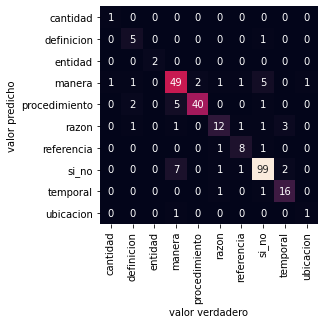

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       0.83      0.56      0.67         9
      entidad       1.00      1.00      1.00         2
       manera       0.80      0.78      0.79        63
procedimiento       0.83      0.95      0.89        42
        razon       0.63      0.75      0.69        16
   referencia       0.80      0.73      0.76        11
        si_no       0.90      0.91      0.90       109
     temporal       0.89      0.76      0.82        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.84       277
    macro avg       0.82      0.74      0.77       277
 weighted avg       0.84      0.84      0.84       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.86
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.856


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,0.269255,0.021466,0.036123,0.005344,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.855856,0.819820,0.873874,0.864253,0.886878,0.860136,0.022647,1
89,0.236072,0.012481,0.033303,0.003788,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.860360,0.815315,0.869369,0.868778,0.882353,0.859235,0.023058,2
86,0.254324,0.009241,0.035223,0.001167,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.864865,0.810811,0.869369,0.855204,0.873303,0.854710,0.022764,3
76,0.291393,0.011024,0.037425,0.002246,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.869369,0.810811,0.873874,0.850679,0.864253,0.853797,0.022858,4
55,0.175219,0.006158,0.031251,0.000001,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.860360,0.801802,0.860360,0.841629,0.873303,0.847491,0.024977,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


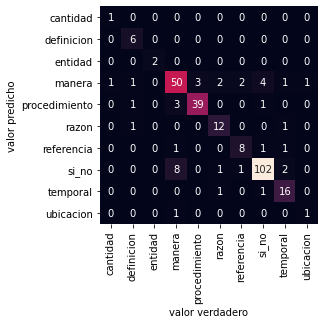

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.77      0.79      0.78        63
procedimiento       0.89      0.93      0.91        42
        razon       0.86      0.75      0.80        16
   referencia       0.73      0.73      0.73        11
        si_no       0.89      0.94      0.91       109
     temporal       0.89      0.76      0.82        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.86       277
    macro avg       0.85      0.76      0.79       277
 weighted avg       0.86      0.86      0.85       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.842
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.866


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,1.608777,0.022902,0.250674,0.009923,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.860360,0.837838,0.837838,0.832579,0.841629,0.842049,0.009598,1
88,1.667903,0.052401,0.266307,0.000895,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.855856,0.833333,0.824324,0.832579,0.846154,0.838449,0.011158,2
67,1.115437,0.039325,0.232504,0.012276,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.842342,0.837838,0.842342,0.819005,0.823529,0.833011,0.009834,3
76,1.747439,0.050633,0.271384,0.011452,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.851351,0.815315,0.828829,0.828054,0.823529,0.829416,0.011974,4
86,1.662370,0.061649,0.256491,0.012957,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.851351,0.824324,0.828829,0.809955,0.828054,0.828503,0.013296,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


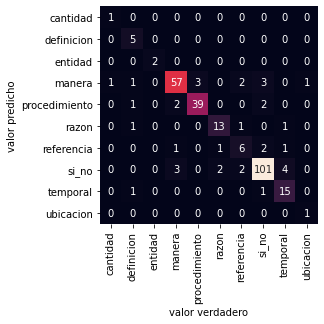

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.56      0.71         9
      entidad       1.00      1.00      1.00         2
       manera       0.84      0.90      0.87        63
procedimiento       0.89      0.93      0.91        42
        razon       0.81      0.81      0.81        16
   referencia       0.55      0.55      0.55        11
        si_no       0.90      0.93      0.91       109
     temporal       0.88      0.71      0.79        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.87       277
    macro avg       0.89      0.74      0.79       277
 weighted avg       0.87      0.87      0.86       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.847
- Mejores parametros: {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.848


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
91,0.394191,0.011304,0.047098,4.406217e-04,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.842342,0.815315,0.869369,0.855204,0.855204,0.847487,0.018218,1
79,0.391295,0.034347,0.046876,9.881590e-03,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.819820,0.810811,0.873874,0.859729,0.859729,0.844792,0.024780,2
67,0.407153,0.009918,0.047097,4.387390e-04,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.824324,0.819820,0.864865,0.846154,0.868778,0.844788,0.020113,3
55,0.444453,0.012160,0.051033,2.098739e-03,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.851351,0.801802,0.851351,0.864253,0.832579,0.840267,0.021724,4
89,0.484170,0.001627,0.046877,4.370285e-07,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.824324,0.819820,0.842342,0.846154,0.846154,0.835759,0.011351,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


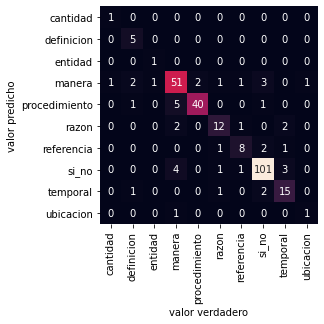

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.56      0.71         9
      entidad       1.00      0.50      0.67         2
       manera       0.81      0.81      0.81        63
procedimiento       0.85      0.95      0.90        42
        razon       0.71      0.75      0.73        16
   referencia       0.67      0.73      0.70        11
        si_no       0.92      0.93      0.92       109
     temporal       0.79      0.71      0.75        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.85       277
    macro avg       0.82      0.69      0.74       277
 weighted avg       0.85      0.85      0.85       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.843
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.83


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.714369,0.026678,0.000601,0.000490,100,{'C': 100},0.891892,0.792793,0.801802,0.864253,0.864253,0.842999,0.038761,1
4,0.589279,0.031954,0.003326,0.006163,10,{'C': 10},0.869369,0.797297,0.810811,0.850679,0.868778,0.839387,0.029928,2
3,0.407018,0.031407,0.000000,0.000000,1,{'C': 1},0.828829,0.788288,0.783784,0.837104,0.846154,0.816832,0.025774,3
2,0.272557,0.011785,0.000000,0.000000,0.1,{'C': 0.1},0.729730,0.725225,0.680180,0.701357,0.737557,0.714810,0.021112,4
1,0.243774,0.007665,0.000206,0.000412,0.01,{'C': 0.01},0.477477,0.459459,0.459459,0.443439,0.434389,0.454845,0.014855,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


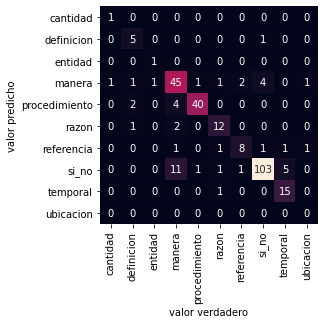

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       0.83      0.56      0.67         9
      entidad       1.00      0.50      0.67         2
       manera       0.79      0.71      0.75        63
procedimiento       0.87      0.95      0.91        42
        razon       0.80      0.75      0.77        16
   referencia       0.62      0.73      0.67        11
        si_no       0.84      0.94      0.89       109
     temporal       0.94      0.71      0.81        21
    ubicacion       0.00      0.00      0.00         2

     accuracy                           0.83       277
    macro avg       0.77      0.64      0.68       277
 weighted avg       0.83      0.83      0.82       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.857
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.848


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.760731,0.025632,0.000000,0.000000,100,{'C': 100},0.851351,0.833333,0.855856,0.873303,0.868778,0.856524,0.014119,1
4,0.520475,0.023788,0.003125,0.006251,10,{'C': 10},0.833333,0.810811,0.837838,0.855204,0.846154,0.836668,0.014931,2
3,0.294217,0.026400,0.003126,0.006251,1,{'C': 1},0.761261,0.761261,0.725225,0.719457,0.760181,0.745477,0.018982,3
2,0.159382,0.015309,0.000000,0.000000,0.1,{'C': 0.1},0.405405,0.414414,0.405405,0.411765,0.398190,0.407036,0.005663,4
0,0.306316,0.023949,0.000000,0.000000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


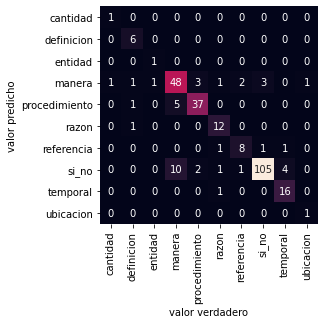

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      0.50      0.67         2
       manera       0.79      0.76      0.77        63
procedimiento       0.86      0.88      0.87        42
        razon       0.92      0.75      0.83        16
   referencia       0.73      0.73      0.73        11
        si_no       0.85      0.96      0.91       109
     temporal       0.94      0.76      0.84        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.85       277
    macro avg       0.91      0.70      0.77       277
 weighted avg       0.85      0.85      0.85       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.843
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.841


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,3.007125,0.073490,0.0000,0.000000,100,{'C': 100},0.851351,0.824324,0.855856,0.855204,0.828054,0.842958,0.013828,1
4,2.128226,0.094381,0.0000,0.000000,10,{'C': 10},0.833333,0.810811,0.819820,0.841629,0.809955,0.823110,0.012511,2
3,1.180903,0.085168,0.0000,0.000000,1,{'C': 1},0.729730,0.716216,0.729730,0.714932,0.705882,0.719298,0.009232,3
2,0.583126,0.037784,0.0000,0.000000,0.1,{'C': 0.1},0.400901,0.405405,0.409910,0.407240,0.407240,0.406139,0.002987,4
0,1.111862,0.141140,0.0002,0.000401,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


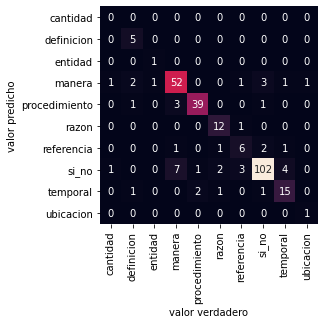

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       1.00      0.56      0.71         9
      entidad       1.00      0.50      0.67         2
       manera       0.84      0.83      0.83        63
procedimiento       0.89      0.93      0.91        42
        razon       0.92      0.75      0.83        16
   referencia       0.55      0.55      0.55        11
        si_no       0.85      0.94      0.89       109
     temporal       0.75      0.71      0.73        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.84       277
    macro avg       0.78      0.63      0.68       277
 weighted avg       0.84      0.84      0.84       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.833
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.845


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.775313,0.035433,0.003124,0.006249,100,{'C': 100},0.819820,0.806306,0.828829,0.864253,0.846154,0.833072,0.020265,1
4,1.314554,0.087875,0.000000,0.000000,10,{'C': 10},0.819820,0.801802,0.797297,0.832579,0.814480,0.813196,0.012679,2
3,0.792956,0.077441,0.000000,0.000000,1,{'C': 1},0.693694,0.662162,0.707207,0.656109,0.701357,0.684106,0.020922,3
0,0.798308,0.041373,0.000000,0.000000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,4
1,0.351213,0.013414,0.000000,0.000000,0.01,{'C': 0.01},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


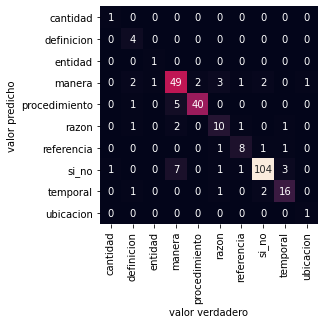

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.44      0.62         9
      entidad       1.00      0.50      0.67         2
       manera       0.80      0.78      0.79        63
procedimiento       0.87      0.95      0.91        42
        razon       0.67      0.62      0.65        16
   referencia       0.73      0.73      0.73        11
        si_no       0.89      0.95      0.92       109
     temporal       0.80      0.76      0.78        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.84       277
    macro avg       0.88      0.67      0.74       277
 weighted avg       0.85      0.84      0.84       277


CARGA DE DATASET: DS1 - TRAINING SET Y TESTING SET

TRAINING SET y TESTING SET: Obtenidos desde el mismo archivo
LECTURA DEL ARCHIVO: DS1_usuario_afip.csv
   IUCA                 

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.986
- Accuracy Score - cross-validation: 0.728
- Mejores parametros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.718


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
76,0.197097,0.007839,0.018751,0.006250,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.716216,0.725225,0.783784,0.728507,0.687783,0.728303,0.031227,1
64,0.203351,0.000433,0.021876,0.007655,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.729730,0.720721,0.774775,0.733032,0.674208,0.726493,0.032098,2
87,0.163269,0.007170,0.018751,0.006250,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.702703,0.747748,0.738739,0.723982,0.683258,0.719286,0.023595,3
88,0.183492,0.009574,0.025001,0.007655,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.702703,0.711712,0.765766,0.723982,0.678733,0.716579,0.028715,4
86,0.165846,0.007839,0.021876,0.007656,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.689189,0.720721,0.729730,0.728507,0.683258,0.710281,0.019973,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


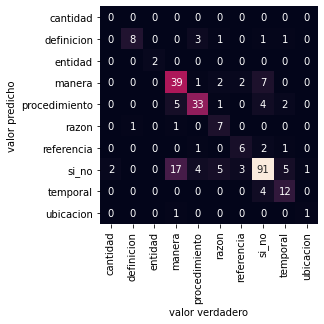

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.57      0.89      0.70         9
      entidad       1.00      1.00      1.00         2
       manera       0.76      0.62      0.68        63
procedimiento       0.73      0.79      0.76        42
        razon       0.78      0.44      0.56        16
   referencia       0.60      0.55      0.57        11
        si_no       0.71      0.83      0.77       109
     temporal       0.75      0.57      0.65        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.72       277
    macro avg       0.64      0.62      0.62       277
 weighted avg       0.72      0.72      0.71       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.952
- Accuracy Score - cross-validation: 0.737
- Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.74


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,0.181470,0.016232,0.015628,0.000002,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.716216,0.725225,0.783784,0.733032,0.728507,0.737353,0.023860,1
76,0.191071,0.011595,0.015626,0.000001,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.725225,0.711712,0.774775,0.733032,0.719457,0.732840,0.022100,2
55,0.152361,0.007843,0.018935,0.002022,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.734234,0.711712,0.743243,0.714932,0.733032,0.727431,0.012091,3
88,0.181484,0.007848,0.021875,0.007654,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.693694,0.707207,0.738739,0.719457,0.710407,0.713901,0.014921,4
66,0.269214,0.006046,0.028127,0.006251,5,1,rbf,"{'C': 5, 'gamma': 1, 'kernel': 'rbf'}",0.702703,0.680180,0.734234,0.719457,0.719457,0.711206,0.018446,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


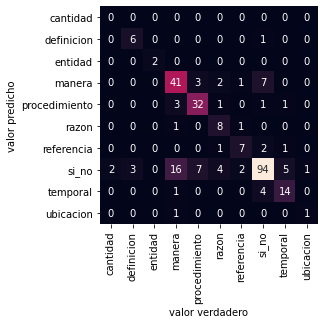

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.86      0.67      0.75         9
      entidad       1.00      1.00      1.00         2
       manera       0.76      0.65      0.70        63
procedimiento       0.84      0.76      0.80        42
        razon       0.80      0.50      0.62        16
   referencia       0.64      0.64      0.64        11
        si_no       0.70      0.86      0.77       109
     temporal       0.74      0.67      0.70        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.74       277
    macro avg       0.68      0.62      0.65       277
 weighted avg       0.74      0.74      0.73       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 5695
Vocabulario: [' 07', ' 072', ' 12', ' 12 ', ' 1e', ' 1er', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 30', ' 30 ', ' 6 ']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.99
- Accuracy Score - cross-validation: 0.727
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.74


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,1.255155,0.018338,0.182872,0.009281,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.707207,0.725225,0.756757,0.719457,0.728507,0.727431,0.016362,1
76,1.214825,0.012228,0.175009,0.011692,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.729730,0.752252,0.716216,0.705882,0.710407,0.722898,0.016724,2
86,1.164016,0.037596,0.181693,0.012186,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.720721,0.743243,0.720721,0.714932,0.710407,0.722005,0.011304,3
89,1.180119,0.023728,0.168758,0.015309,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.684685,0.725225,0.743243,0.719457,0.723982,0.719318,0.019124,4
67,0.871587,0.008637,0.167083,0.006310,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.698198,0.729730,0.693694,0.728507,0.719457,0.713917,0.015164,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


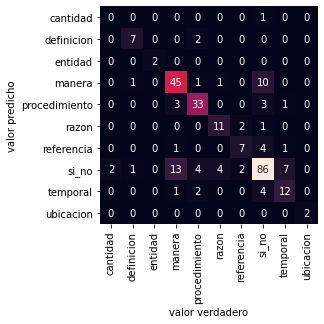

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.78      0.78      0.78         9
      entidad       1.00      1.00      1.00         2
       manera       0.78      0.71      0.74        63
procedimiento       0.82      0.79      0.80        42
        razon       0.79      0.69      0.73        16
   referencia       0.54      0.64      0.58        11
        si_no       0.72      0.79      0.75       109
     temporal       0.63      0.57      0.60        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.74       277
    macro avg       0.71      0.70      0.70       277
 weighted avg       0.74      0.74      0.74       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.957
- Accuracy Score - cross-validation: 0.731
- Mejores parametros: {'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=2, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.726


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
55,0.278776,0.014578,0.021876,7.654753e-03,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.743243,0.707207,0.747748,0.755656,0.701357,0.731042,0.022285,1
67,0.250233,0.024066,0.021877,7.655259e-03,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.734234,0.711712,0.743243,0.723982,0.714932,0.725621,0.011791,2
79,0.275228,0.023593,0.021876,7.655473e-03,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.734234,0.698198,0.747748,0.719457,0.701357,0.720199,0.018950,3
91,0.263804,0.010759,0.028048,6.212917e-03,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.729730,0.707207,0.747748,0.719457,0.696833,0.720195,0.017692,4
86,0.309824,0.006486,0.031251,6.143617e-07,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.725225,0.684685,0.729730,0.728507,0.714932,0.716616,0.016792,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


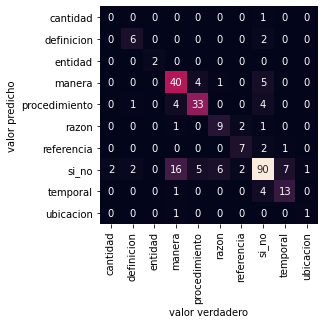

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.75      0.67      0.71         9
      entidad       1.00      1.00      1.00         2
       manera       0.80      0.63      0.71        63
procedimiento       0.79      0.79      0.79        42
        razon       0.69      0.56      0.62        16
   referencia       0.70      0.64      0.67        11
        si_no       0.69      0.83      0.75       109
     temporal       0.72      0.62      0.67        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.73       277
    macro avg       0.66      0.62      0.64       277
 weighted avg       0.73      0.73      0.72       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.985
- Accuracy Score - cross-validation: 0.735
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.704


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.477201,0.025602,0.001001,0.000634,10,{'C': 10},0.711712,0.738739,0.752252,0.742081,0.728507,0.734658,0.013753,1
3,0.241211,0.009676,0.000000,0.000000,1,{'C': 1},0.693694,0.738739,0.711712,0.746606,0.723982,0.722946,0.018933,2
5,0.836611,0.097380,0.006251,0.007656,100,{'C': 100},0.689189,0.734234,0.729730,0.733032,0.683258,0.713889,0.022714,3
2,0.152963,0.004533,0.003125,0.006250,0.1,{'C': 0.1},0.603604,0.612613,0.599099,0.606335,0.615385,0.607407,0.005922,4
1,0.139815,0.013234,0.000200,0.000400,0.01,{'C': 0.01},0.400901,0.396396,0.391892,0.398190,0.389140,0.395304,0.004254,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


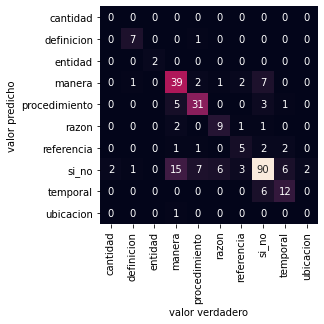

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.88      0.78      0.82         9
      entidad       1.00      1.00      1.00         2
       manera       0.75      0.62      0.68        63
procedimiento       0.78      0.74      0.76        42
        razon       0.69      0.56      0.62        16
   referencia       0.45      0.45      0.45        11
        si_no       0.68      0.83      0.75       109
     temporal       0.67      0.57      0.62        21
    ubicacion       0.00      0.00      0.00         2

     accuracy                           0.70       277
    macro avg       0.59      0.55      0.57       277
 weighted avg       0.70      0.70      0.70       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.977
- Accuracy Score - cross-validation: 0.736
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.729


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.512972,0.027078,0.00000,0.0000,10,{'C': 10},0.711712,0.752252,0.747748,0.760181,0.710407,0.736460,0.021122,1
5,0.847001,0.010140,0.00645,0.0075,100,{'C': 100},0.693694,0.743243,0.738739,0.728507,0.701357,0.721108,0.019986,2
3,0.275466,0.012170,0.00000,0.0000,1,{'C': 1},0.662162,0.653153,0.657658,0.669683,0.669683,0.662468,0.006544,3
2,0.147305,0.008200,0.00000,0.0000,0.1,{'C': 0.1},0.396396,0.400901,0.396396,0.398190,0.393665,0.397110,0.002384,4
0,0.285053,0.022737,0.00000,0.0000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


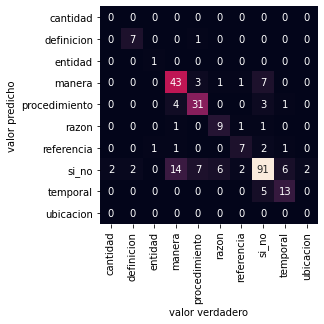

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.88      0.78      0.82         9
      entidad       1.00      0.50      0.67         2
       manera       0.78      0.68      0.73        63
procedimiento       0.79      0.74      0.77        42
        razon       0.75      0.56      0.64        16
   referencia       0.58      0.64      0.61        11
        si_no       0.69      0.83      0.76       109
     temporal       0.72      0.62      0.67        21
    ubicacion       0.00      0.00      0.00         2

     accuracy                           0.73       277
    macro avg       0.62      0.54      0.57       277
 weighted avg       0.73      0.73      0.72       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 5695
Vocabulario: [' 07', ' 072', ' 12', ' 12 ', ' 1e', ' 1er', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 30', ' 30 ', ' 6 ']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.99
- Accuracy Score - cross-validation: 0.742
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.733


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,3.039957,0.137793,0.000000,0.00000,100,{'C': 100},0.702703,0.747748,0.747748,0.755656,0.755656,0.741902,0.019916,1
4,1.978508,0.056568,0.000200,0.00040,10,{'C': 10},0.716216,0.729730,0.743243,0.701357,0.728507,0.723811,0.014118,2
3,1.039293,0.064745,0.000000,0.00000,1,{'C': 1},0.657658,0.657658,0.635135,0.624434,0.642534,0.643484,0.012925,3
2,0.523205,0.047521,0.000000,0.00000,0.1,{'C': 0.1},0.405405,0.405405,0.400901,0.402715,0.389140,0.400713,0.006033,4
0,1.033058,0.071466,0.003125,0.00625,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


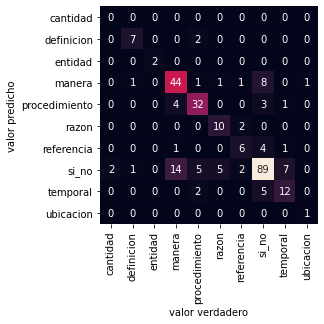

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.78      0.78      0.78         9
      entidad       1.00      1.00      1.00         2
       manera       0.77      0.70      0.73        63
procedimiento       0.80      0.76      0.78        42
        razon       0.83      0.62      0.71        16
   referencia       0.50      0.55      0.52        11
        si_no       0.71      0.82      0.76       109
     temporal       0.63      0.57      0.60        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.73       277
    macro avg       0.70      0.63      0.66       277
 weighted avg       0.73      0.73      0.73       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.99
- Accuracy Score - cross-validation: 0.727
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.744


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.624394,0.064632,0.003125,0.00625,100,{'C': 100},0.729730,0.707207,0.747748,0.737557,0.710407,0.726530,0.015591,1
4,1.183435,0.070900,0.000000,0.00000,10,{'C': 10},0.680180,0.675676,0.707207,0.723982,0.696833,0.696776,0.017718,2
3,0.620293,0.048484,0.000000,0.00000,1,{'C': 1},0.617117,0.585586,0.576577,0.601810,0.588235,0.593865,0.014163,3
0,0.651308,0.077784,0.000000,0.00000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,4
1,0.262734,0.011760,0.000000,0.00000,0.01,{'C': 0.01},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


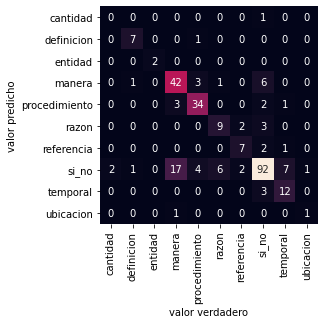

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.88      0.78      0.82         9
      entidad       1.00      1.00      1.00         2
       manera       0.79      0.67      0.72        63
procedimiento       0.85      0.81      0.83        42
        razon       0.64      0.56      0.60        16
   referencia       0.70      0.64      0.67        11
        si_no       0.70      0.84      0.76       109
     temporal       0.80      0.57      0.67        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.74       277
    macro avg       0.69      0.64      0.66       277
 weighted avg       0.75      0.74      0.74       277


CARGA DE DATASET: DS1 - TRAINING SET Y TESTING SET

TRAINING SET y TESTING SET: Obtenidos desde el mismo archivo
LECTURA DEL ARCHIVO: DS1_usuario_afip.csv
   IUCA                 

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.838
- Mejores parametros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.859


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
76,0.206896,0.012111,0.025001,0.007655,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.851351,0.788288,0.864865,0.850679,0.832579,0.837552,0.026685,1
88,0.213172,0.015550,0.028126,0.006251,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.851351,0.788288,0.864865,0.850679,0.832579,0.837552,0.026685,1
64,0.219183,0.014222,0.021877,0.007655,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.846847,0.783784,0.864865,0.846154,0.823529,0.833036,0.027900,3
86,0.146881,0.007657,0.018752,0.006251,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.837838,0.801802,0.828829,0.819005,0.855204,0.828535,0.017907,4
52,0.200232,0.006375,0.021877,0.007655,2,0.1,rbf,"{'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}",0.846847,0.774775,0.842342,0.841629,0.823529,0.825824,0.026743,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


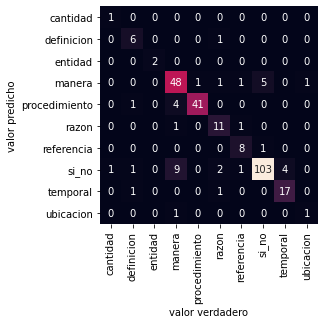

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       0.86      0.67      0.75         9
      entidad       1.00      1.00      1.00         2
       manera       0.84      0.76      0.80        63
procedimiento       0.89      0.98      0.93        42
        razon       0.85      0.69      0.76        16
   referencia       0.89      0.73      0.80        11
        si_no       0.85      0.94      0.90       109
     temporal       0.89      0.81      0.85        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.86       277
    macro avg       0.86      0.76      0.80       277
 weighted avg       0.86      0.86      0.86       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.856
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.838


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,0.187184,0.014353,0.028553,0.005952,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.837838,0.806306,0.896396,0.868778,0.868778,0.855619,0.030845,1
89,0.178361,0.007481,0.018751,0.006250,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.828829,0.788288,0.878378,0.873303,0.859729,0.845705,0.033488,2
86,0.182313,0.006950,0.025043,0.007689,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.842342,0.783784,0.864865,0.864253,0.859729,0.842995,0.030714,3
76,0.197107,0.007845,0.025000,0.007655,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.851351,0.788288,0.864865,0.855204,0.841629,0.840267,0.027036,4
55,0.121882,0.018223,0.025000,0.007655,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.828829,0.783784,0.860360,0.850679,0.859729,0.836676,0.028801,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


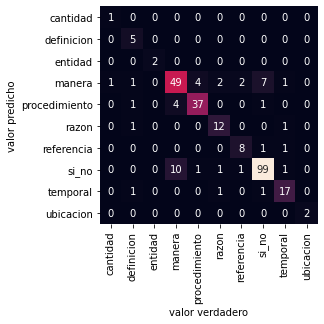

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.56      0.71         9
      entidad       1.00      1.00      1.00         2
       manera       0.73      0.78      0.75        63
procedimiento       0.86      0.88      0.87        42
        razon       0.86      0.75      0.80        16
   referencia       0.80      0.73      0.76        11
        si_no       0.88      0.91      0.89       109
     temporal       0.85      0.81      0.83        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.84       277
    macro avg       0.90      0.79      0.83       277
 weighted avg       0.84      0.84      0.84       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.844
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.863


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,1.278955,0.029558,0.200656,0.006056,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.828829,0.824324,0.864865,0.859729,0.841629,0.843875,0.016159,1
88,1.380416,0.044298,0.209814,0.015984,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.833333,0.828829,0.864865,0.855204,0.832579,0.842962,0.014352,2
86,1.267453,0.068127,0.203383,0.014260,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.833333,0.806306,0.873874,0.837104,0.832579,0.836639,0.021606,3
55,0.967240,0.018302,0.184384,0.015311,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.846847,0.815315,0.846847,0.837104,0.832579,0.835738,0.011625,4
76,1.386423,0.070033,0.212724,0.019005,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.824324,0.810811,0.869369,0.841629,0.828054,0.834838,0.019861,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


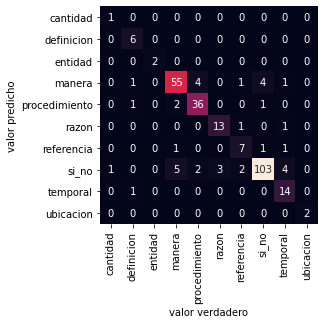

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.83      0.87      0.85        63
procedimiento       0.90      0.86      0.88        42
        razon       0.87      0.81      0.84        16
   referencia       0.70      0.64      0.67        11
        si_no       0.86      0.94      0.90       109
     temporal       0.93      0.67      0.78        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.86       277
    macro avg       0.91      0.80      0.84       277
 weighted avg       0.87      0.86      0.86       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.841
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.863


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,0.385495,0.006388,0.031252,1.302385e-06,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.833333,0.824324,0.846847,0.859729,0.841629,0.841172,0.012017,1
91,0.324639,0.006104,0.031252,1.451027e-06,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.837838,0.806306,0.878378,0.864253,0.819005,0.841156,0.026964,2
55,0.284389,0.026884,0.031464,4.254113e-04,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.846847,0.806306,0.855856,0.855204,0.837104,0.840263,0.018291,3
67,0.292090,0.006616,0.031251,8.395585e-07,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.833333,0.819820,0.864865,0.859729,0.819005,0.839350,0.019483,4
79,0.317245,0.006022,0.031252,4.672031e-07,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.819820,0.815315,0.869369,0.864253,0.819005,0.837552,0.023993,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


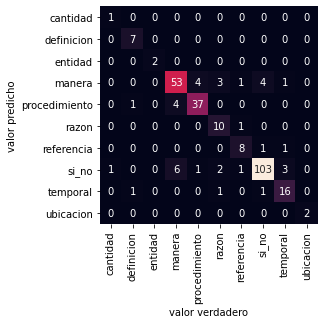

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.78      0.88         9
      entidad       1.00      1.00      1.00         2
       manera       0.80      0.84      0.82        63
procedimiento       0.88      0.88      0.88        42
        razon       0.91      0.62      0.74        16
   referencia       0.80      0.73      0.76        11
        si_no       0.88      0.94      0.91       109
     temporal       0.84      0.76      0.80        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.86       277
    macro avg       0.91      0.81      0.85       277
 weighted avg       0.86      0.86      0.86       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.836
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.812


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.669705,0.019506,0.003926,0.005884,100,{'C': 100},0.860360,0.779279,0.828829,0.837104,0.873303,0.835775,0.032418,1
4,0.504938,0.030140,0.003125,0.006251,10,{'C': 10},0.860360,0.788288,0.824324,0.841629,0.855204,0.833961,0.026022,2
3,0.300482,0.018362,0.003125,0.006250,1,{'C': 1},0.824324,0.788288,0.810811,0.828054,0.846154,0.819526,0.019269,3
2,0.222877,0.009142,0.000000,0.000000,0.1,{'C': 0.1},0.729730,0.716216,0.693694,0.678733,0.751131,0.713901,0.025640,4
1,0.195703,0.007141,0.000201,0.000401,0.01,{'C': 0.01},0.468468,0.423423,0.436937,0.438914,0.425339,0.438616,0.016132,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


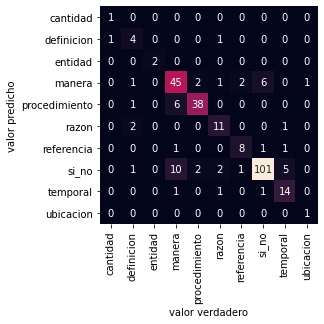

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       0.67      0.44      0.53         9
      entidad       1.00      1.00      1.00         2
       manera       0.78      0.71      0.74        63
procedimiento       0.84      0.90      0.87        42
        razon       0.79      0.69      0.73        16
   referencia       0.73      0.73      0.73        11
        si_no       0.83      0.93      0.87       109
     temporal       0.82      0.67      0.74        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.81       277
    macro avg       0.85      0.71      0.76       277
 weighted avg       0.81      0.81      0.81       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.849
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.83


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.778684,0.064232,0.000000,0.000000,100,{'C': 100},0.846847,0.824324,0.855856,0.864253,0.855204,0.849297,0.013647,1
4,0.576206,0.035557,0.003125,0.006250,10,{'C': 10},0.833333,0.801802,0.846847,0.859729,0.841629,0.836668,0.019426,2
3,0.322154,0.023634,0.003124,0.006248,1,{'C': 1},0.738739,0.756757,0.765766,0.737557,0.751131,0.749990,0.010744,3
2,0.160954,0.019531,0.000220,0.000440,0.1,{'C': 0.1},0.414414,0.414414,0.409910,0.407240,0.407240,0.410644,0.003229,4
0,0.317087,0.019524,0.000000,0.000000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


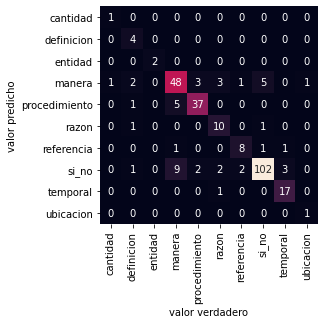

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.44      0.62         9
      entidad       1.00      1.00      1.00         2
       manera       0.75      0.76      0.76        63
procedimiento       0.86      0.88      0.87        42
        razon       0.83      0.62      0.71        16
   referencia       0.73      0.73      0.73        11
        si_no       0.84      0.94      0.89       109
     temporal       0.94      0.81      0.87        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.83       277
    macro avg       0.90      0.72      0.78       277
 weighted avg       0.84      0.83      0.83       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.839
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.852


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.630770,0.081305,0.000000,0.000000,100,{'C': 100},0.833333,0.842342,0.864865,0.832579,0.823529,0.839330,0.014088,1
4,2.013124,0.082664,0.000000,0.000000,10,{'C': 10},0.819820,0.810811,0.819820,0.841629,0.800905,0.818597,0.013469,2
3,1.170466,0.081509,0.003125,0.006250,1,{'C': 1},0.738739,0.711712,0.711712,0.710407,0.705882,0.715690,0.011722,3
2,0.566978,0.040170,0.000401,0.000801,0.1,{'C': 0.1},0.405405,0.405405,0.418919,0.402715,0.402715,0.407032,0.006064,4
0,1.029282,0.065446,0.000000,0.000000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


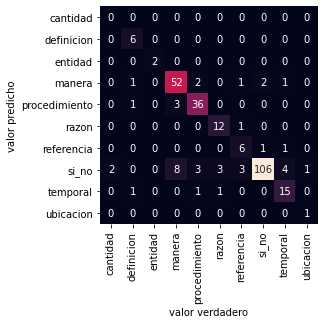

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.88      0.83      0.85        63
procedimiento       0.90      0.86      0.88        42
        razon       0.92      0.75      0.83        16
   referencia       0.75      0.55      0.63        11
        si_no       0.82      0.97      0.89       109
     temporal       0.83      0.71      0.77        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.85       277
    macro avg       0.81      0.68      0.73       277
 weighted avg       0.85      0.85      0.85       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.838
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.838


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.461966,0.070247,0.000000,0.000000,100,{'C': 100},0.846847,0.806306,0.860360,0.850679,0.823529,0.837544,0.019758,1
4,1.110396,0.040010,0.003125,0.006250,10,{'C': 10},0.824324,0.792793,0.842342,0.828054,0.809955,0.819494,0.016868,2
3,0.714319,0.079258,0.003125,0.006250,1,{'C': 1},0.684685,0.675676,0.680180,0.656109,0.674208,0.674171,0.009748,3
2,0.378647,0.023010,0.000000,0.000000,0.1,{'C': 0.1},0.387387,0.387387,0.387387,0.389140,0.393665,0.388994,0.002432,4
0,0.685068,0.076377,0.003124,0.006249,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


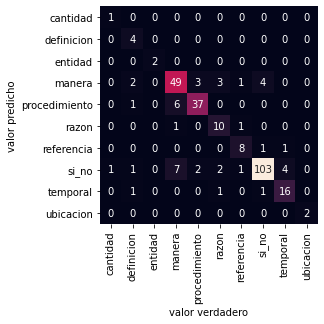

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.44      0.62         9
      entidad       1.00      1.00      1.00         2
       manera       0.79      0.78      0.78        63
procedimiento       0.84      0.88      0.86        42
        razon       0.83      0.62      0.71        16
   referencia       0.80      0.73      0.76        11
        si_no       0.85      0.94      0.90       109
     temporal       0.84      0.76      0.80        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.84       277
    macro avg       0.90      0.77      0.81       277
 weighted avg       0.84      0.84      0.83       277


CARGA DE DATASET: DS1 - TRAINING SET Y TESTING SET

TRAINING SET y TESTING SET: Obtenidos desde el mismo archivo
LECTURA DEL ARCHIVO: DS1_usuario_afip.csv
   IUCA                 

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.977
- Accuracy Score - cross-validation: 0.827
- Mejores parametros: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.823


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
74,0.162958,0.012866,0.031251,0.009883,10,0.01,rbf,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.873874,0.774775,0.806306,0.828054,0.850679,0.826738,0.034393,1
86,0.159384,0.011693,0.032229,0.007372,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.869369,0.801802,0.810811,0.809955,0.837104,0.825808,0.024810,2
87,0.160423,0.005926,0.029052,0.004396,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.864865,0.788288,0.806306,0.800905,0.828054,0.817684,0.026865,3
84,0.172539,0.013756,0.025002,0.007655,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.855856,0.756757,0.801802,0.819005,0.846154,0.815915,0.035265,4
76,0.309827,0.011536,0.034378,0.006250,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.815315,0.779279,0.797297,0.814480,0.800905,0.801455,0.013199,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


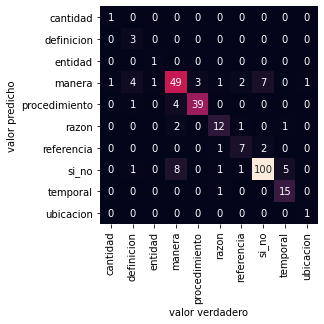

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.33      0.50         9
      entidad       1.00      0.50      0.67         2
       manera       0.71      0.78      0.74        63
procedimiento       0.89      0.93      0.91        42
        razon       0.75      0.75      0.75        16
   referencia       0.70      0.64      0.67        11
        si_no       0.86      0.92      0.89       109
     temporal       0.94      0.71      0.81        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.82       277
    macro avg       0.88      0.66      0.73       277
 weighted avg       0.83      0.82      0.82       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.863
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.852


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,0.216299,0.006064,0.028126,0.006252,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.864865,0.819820,0.882883,0.859729,0.886878,0.862835,0.023850,1
89,0.225443,0.015987,0.031250,0.000002,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.855856,0.819820,0.887387,0.864253,0.882353,0.861934,0.024003,2
86,0.221886,0.022965,0.031462,0.009891,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.878378,0.815315,0.873874,0.850679,0.877828,0.859215,0.024202,3
76,0.253040,0.011751,0.037503,0.007656,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.873874,0.819820,0.869369,0.850679,0.864253,0.855599,0.019508,4
55,0.165843,0.012870,0.025002,0.007655,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.860360,0.810811,0.855856,0.846154,0.873303,0.849297,0.021132,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


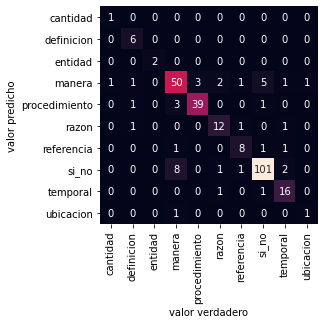

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.77      0.79      0.78        63
procedimiento       0.89      0.93      0.91        42
        razon       0.80      0.75      0.77        16
   referencia       0.73      0.73      0.73        11
        si_no       0.89      0.93      0.91       109
     temporal       0.89      0.76      0.82        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.85       277
    macro avg       0.85      0.76      0.79       277
 weighted avg       0.85      0.85      0.85       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.841
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.874


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,1.495930,0.049464,0.226591,0.009856,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.860360,0.824324,0.842342,0.837104,0.841629,0.841152,0.011577,1
88,1.679153,0.088008,0.253403,0.011663,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.860360,0.828829,0.828829,0.828054,0.850679,0.839350,0.013556,2
86,1.622902,0.016174,0.254592,0.009520,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.851351,0.810811,0.815315,0.823529,0.841629,0.828527,0.015531,3
76,1.799075,0.077269,0.282631,0.010255,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.851351,0.806306,0.815315,0.828054,0.837104,0.827626,0.015868,4
55,1.151813,0.035494,0.219216,0.009899,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.842342,0.810811,0.806306,0.828054,0.828054,0.823114,0.013057,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


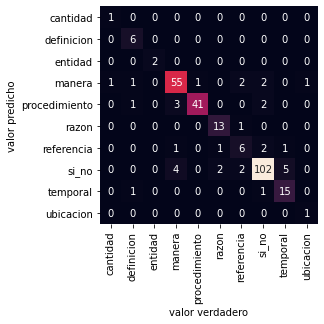

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.87      0.87      0.87        63
procedimiento       0.87      0.98      0.92        42
        razon       0.93      0.81      0.87        16
   referencia       0.55      0.55      0.55        11
        si_no       0.89      0.94      0.91       109
     temporal       0.88      0.71      0.79        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.87       277
    macro avg       0.90      0.75      0.80       277
 weighted avg       0.88      0.87      0.87       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.847
- Mejores parametros: {'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.852


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
91,0.398576,0.016063,0.050220,6.156055e-03,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.828829,0.810811,0.869369,0.864253,0.859729,0.846598,0.022800,1
67,0.391746,0.021325,0.050003,6.251788e-03,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.824324,0.815315,0.860360,0.855204,0.859729,0.842986,0.019211,2
79,0.419203,0.015414,0.046878,5.761645e-07,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.815315,0.810811,0.860360,0.864253,0.859729,0.842094,0.023797,3
88,0.523187,0.016297,0.056253,7.654889e-03,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.815315,0.819820,0.851351,0.832579,0.837104,0.831234,0.012843,4
55,0.412953,0.027524,0.050214,6.674838e-03,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.828829,0.792793,0.842342,0.859729,0.828054,0.830349,0.022023,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


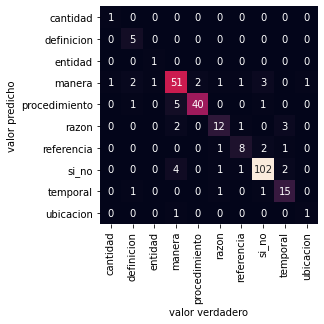

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.56      0.71         9
      entidad       1.00      0.50      0.67         2
       manera       0.81      0.81      0.81        63
procedimiento       0.85      0.95      0.90        42
        razon       0.67      0.75      0.71        16
   referencia       0.67      0.73      0.70        11
        si_no       0.93      0.94      0.93       109
     temporal       0.83      0.71      0.77        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.85       277
    macro avg       0.83      0.69      0.74       277
 weighted avg       0.86      0.85      0.85       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.843
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.834


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.781977,0.019974,0.0,0.0,100,{'C': 100},0.896396,0.810811,0.806306,0.846154,0.855204,0.842974,0.032841,1
4,0.651333,0.022694,0.0,0.0,10,{'C': 10},0.887387,0.801802,0.806306,0.846154,0.868778,0.842086,0.033717,2
3,0.431720,0.037377,0.0,0.0,1,{'C': 1},0.846847,0.774775,0.797297,0.837104,0.846154,0.820435,0.029179,3
2,0.335523,0.016672,0.0,0.0,0.1,{'C': 0.1},0.734234,0.716216,0.680180,0.696833,0.733032,0.712099,0.020962,4
1,0.284619,0.011947,0.0,0.0,0.01,{'C': 0.01},0.477477,0.450450,0.454955,0.447964,0.425339,0.451237,0.016640,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


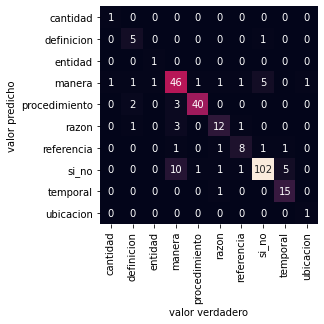

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       0.83      0.56      0.67         9
      entidad       1.00      0.50      0.67         2
       manera       0.79      0.73      0.76        63
procedimiento       0.89      0.95      0.92        42
        razon       0.71      0.75      0.73        16
   referencia       0.67      0.73      0.70        11
        si_no       0.85      0.94      0.89       109
     temporal       0.94      0.71      0.81        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.83       277
    macro avg       0.87      0.69      0.75       277
 weighted avg       0.84      0.83      0.83       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.851
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.845


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.816565,0.045741,0.000000,0.000000,100,{'C': 100},0.855856,0.837838,0.851351,0.850679,0.859729,0.851090,0.007392,1
4,0.554549,0.020616,0.000000,0.000000,10,{'C': 10},0.833333,0.810811,0.833333,0.855204,0.841629,0.834862,0.014441,2
3,0.306493,0.025589,0.000000,0.000000,1,{'C': 1},0.752252,0.761261,0.725225,0.714932,0.764706,0.743675,0.019958,3
2,0.165861,0.012902,0.003125,0.006251,0.1,{'C': 0.1},0.409910,0.414414,0.405405,0.411765,0.402715,0.408842,0.004245,4
0,0.363119,0.038674,0.000000,0.000000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


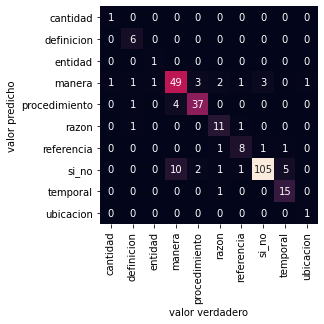

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      0.50      0.67         2
       manera       0.79      0.78      0.78        63
procedimiento       0.88      0.88      0.88        42
        razon       0.85      0.69      0.76        16
   referencia       0.73      0.73      0.73        11
        si_no       0.85      0.96      0.90       109
     temporal       0.94      0.71      0.81        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.84       277
    macro avg       0.90      0.69      0.77       277
 weighted avg       0.85      0.84      0.84       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.838
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.848


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,3.131102,0.211015,0.000400,0.000801,100,{'C': 100},0.842342,0.824324,0.855856,0.846154,0.823529,0.838441,0.012646,1
4,2.348002,0.120942,0.006250,0.007655,10,{'C': 10},0.828829,0.815315,0.828829,0.828054,0.814480,0.823101,0.006710,2
3,1.234333,0.089412,0.003125,0.006249,1,{'C': 1},0.729730,0.707207,0.716216,0.719457,0.710407,0.716603,0.007839,3
2,0.656749,0.047877,0.003125,0.006250,0.1,{'C': 0.1},0.400901,0.409910,0.414414,0.407240,0.402715,0.407036,0.004880,4
0,1.192933,0.177009,0.009375,0.007655,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


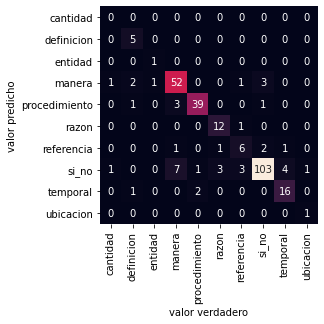

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       1.00      0.56      0.71         9
      entidad       1.00      0.50      0.67         2
       manera       0.87      0.83      0.85        63
procedimiento       0.89      0.93      0.91        42
        razon       0.92      0.75      0.83        16
   referencia       0.55      0.55      0.55        11
        si_no       0.84      0.94      0.89       109
     temporal       0.84      0.76      0.80        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.85       277
    macro avg       0.79      0.63      0.69       277
 weighted avg       0.85      0.85      0.84       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.837
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.845


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.684412,0.056679,0.000000,0.000000,100,{'C': 100},0.824324,0.815315,0.828829,0.859729,0.855204,0.836680,0.017579,1
4,1.274137,0.100474,0.000000,0.000000,10,{'C': 10},0.828829,0.806306,0.806306,0.828054,0.819005,0.817700,0.009924,2
3,0.717665,0.042845,0.003525,0.006066,1,{'C': 1},0.702703,0.666667,0.707207,0.674208,0.714932,0.693143,0.019097,3
0,0.675535,0.065998,0.003125,0.006250,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,4
1,0.345109,0.018097,0.003125,0.006250,0.01,{'C': 0.01},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


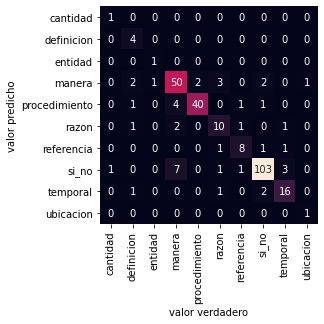

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.44      0.62         9
      entidad       1.00      0.50      0.67         2
       manera       0.82      0.79      0.81        63
procedimiento       0.85      0.95      0.90        42
        razon       0.67      0.62      0.65        16
   referencia       0.73      0.73      0.73        11
        si_no       0.89      0.94      0.92       109
     temporal       0.80      0.76      0.78        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.84       277
    macro avg       0.88      0.67      0.74       277
 weighted avg       0.85      0.84      0.84       277


CARGA DE DATASET: DS1 - TRAINING SET Y TESTING SET

TRAINING SET y TESTING SET: Obtenidos desde el mismo archivo
LECTURA DEL ARCHIVO: DS1_usuario_afip.csv
   IUCA                 

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.839
- Mejores parametros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.859


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
76,0.241899,0.004544,0.028419,0.001201,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.851351,0.797297,0.869369,0.850679,0.828054,0.839350,0.024777,1
88,0.212560,0.012897,0.023785,0.005412,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.851351,0.797297,0.869369,0.850679,0.828054,0.839350,0.024777,1
64,0.228560,0.008009,0.028126,0.006251,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.846847,0.792793,0.869369,0.846154,0.823529,0.835738,0.025909,3
86,0.147698,0.004719,0.023616,0.001021,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.837838,0.806306,0.837838,0.828054,0.855204,0.833048,0.015980,4
52,0.193978,0.018865,0.025001,0.007656,2,0.1,rbf,"{'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}",0.842342,0.774775,0.851351,0.841629,0.814480,0.824915,0.027946,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


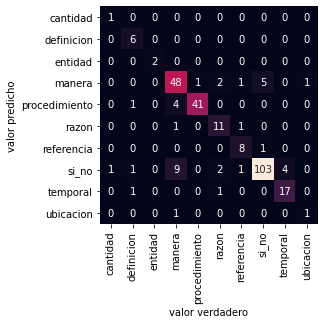

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.83      0.76      0.79        63
procedimiento       0.89      0.98      0.93        42
        razon       0.85      0.69      0.76        16
   referencia       0.89      0.73      0.80        11
        si_no       0.85      0.94      0.90       109
     temporal       0.89      0.81      0.85        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.86       277
    macro avg       0.87      0.76      0.80       277
 weighted avg       0.86      0.86      0.86       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.857
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.841


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,0.198325,0.005791,0.025586,0.005281,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.828829,0.815315,0.896396,0.873303,0.868778,0.856524,0.029956,1
89,0.184385,0.006251,0.025220,0.007394,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.819820,0.801802,0.882883,0.877828,0.868778,0.850222,0.032991,2
86,0.197610,0.005955,0.027480,0.006057,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.842342,0.797297,0.869369,0.873303,0.859729,0.848408,0.027700,3
76,0.199338,0.014019,0.025001,0.007655,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.851351,0.797297,0.869369,0.873303,0.841629,0.846590,0.027238,4
55,0.143981,0.006154,0.021876,0.007655,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.833333,0.797297,0.855856,0.868778,0.850679,0.841189,0.024717,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


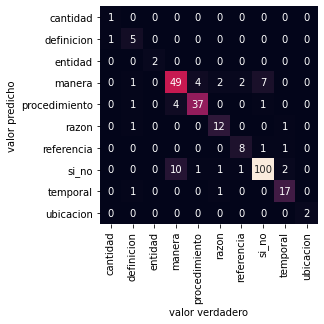

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       0.83      0.56      0.67         9
      entidad       1.00      1.00      1.00         2
       manera       0.75      0.78      0.77        63
procedimiento       0.86      0.88      0.87        42
        razon       0.86      0.75      0.80        16
   referencia       0.80      0.73      0.76        11
        si_no       0.87      0.92      0.89       109
     temporal       0.89      0.81      0.85        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.84       277
    macro avg       0.89      0.79      0.83       277
 weighted avg       0.84      0.84      0.84       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.846
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.863


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,1.303527,0.028489,0.204050,0.009516,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.828829,0.833333,0.869369,0.855204,0.841629,0.845673,0.014864,1
88,1.396002,0.049684,0.215870,0.006383,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.833333,0.824324,0.869369,0.855204,0.832579,0.842962,0.016704,2
76,1.459314,0.012585,0.233803,0.007947,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.824324,0.815315,0.873874,0.846154,0.832579,0.838449,0.020413,3
55,0.943182,0.026227,0.184811,0.014967,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.851351,0.810811,0.851351,0.828054,0.832579,0.834829,0.015322,4
86,1.282880,0.047970,0.209831,0.012841,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.824324,0.806306,0.864865,0.841629,0.832579,0.833941,0.019357,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


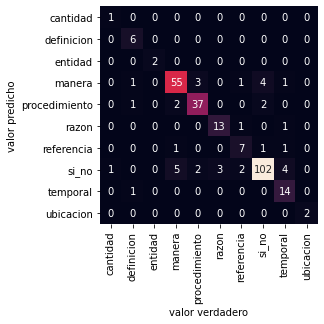

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.85      0.87      0.86        63
procedimiento       0.88      0.88      0.88        42
        razon       0.87      0.81      0.84        16
   referencia       0.70      0.64      0.67        11
        si_no       0.86      0.94      0.89       109
     temporal       0.93      0.67      0.78        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.86       277
    macro avg       0.91      0.80      0.84       277
 weighted avg       0.87      0.86      0.86       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.992
- Accuracy Score - cross-validation: 0.845
- Mejores parametros: {'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=2, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.859


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
55,0.319871,0.011465,0.035639,5.725382e-03,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.846847,0.810811,0.864865,0.859729,0.841629,0.844776,0.018947,1
91,0.322323,0.008019,0.031254,1.377061e-06,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.842342,0.810811,0.882883,0.868778,0.819005,0.844764,0.027756,2
88,0.388587,0.006326,0.040626,7.654539e-03,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.837838,0.833333,0.851351,0.855204,0.841629,0.843871,0.008208,3
89,0.372356,0.015657,0.037502,7.655006e-03,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.833333,0.824324,0.855856,0.859729,0.841629,0.842974,0.013336,4
67,0.325450,0.011811,0.031252,6.503192e-07,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.833333,0.824324,0.869369,0.864253,0.819005,0.842057,0.020788,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


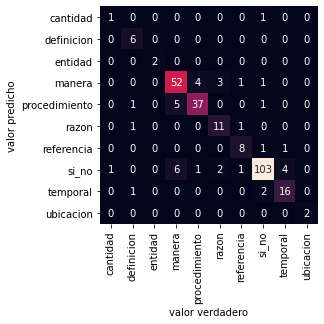

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.50      0.50      0.50         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.85      0.83      0.84        63
procedimiento       0.84      0.88      0.86        42
        razon       0.85      0.69      0.76        16
   referencia       0.80      0.73      0.76        11
        si_no       0.87      0.94      0.91       109
     temporal       0.84      0.76      0.80        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.86       277
    macro avg       0.86      0.80      0.82       277
 weighted avg       0.86      0.86      0.86       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.838
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.809


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.626168,0.034056,0.000000,0.000000,100,{'C': 100},0.860360,0.788288,0.824324,0.841629,0.877828,0.838486,0.030843,1
4,0.478621,0.012153,0.003136,0.006272,10,{'C': 10},0.855856,0.783784,0.824324,0.837104,0.850679,0.830349,0.025745,2
3,0.309832,0.011823,0.000000,0.000000,1,{'C': 1},0.824324,0.788288,0.815315,0.823529,0.850679,0.820427,0.019995,3
2,0.225912,0.008374,0.000000,0.000000,0.1,{'C': 0.1},0.725225,0.716216,0.693694,0.678733,0.746606,0.712095,0.023799,4
1,0.187733,0.014232,0.000000,0.000000,0.01,{'C': 0.01},0.468468,0.423423,0.436937,0.434389,0.425339,0.437711,0.016216,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


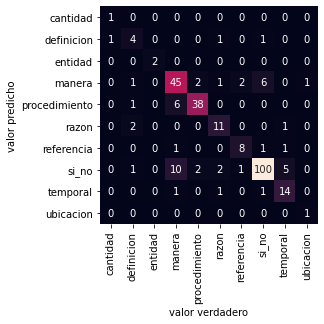

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       0.57      0.44      0.50         9
      entidad       1.00      1.00      1.00         2
       manera       0.78      0.71      0.74        63
procedimiento       0.84      0.90      0.87        42
        razon       0.79      0.69      0.73        16
   referencia       0.73      0.73      0.73        11
        si_no       0.83      0.92      0.87       109
     temporal       0.82      0.67      0.74        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.81       277
    macro avg       0.84      0.71      0.75       277
 weighted avg       0.81      0.81      0.80       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.848
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.83


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.729517,0.021615,0.000000,0.00000,100,{'C': 100},0.846847,0.828829,0.855856,0.859729,0.850679,0.848388,0.010720,1
4,0.507369,0.013145,0.000000,0.00000,10,{'C': 10},0.833333,0.806306,0.846847,0.855204,0.837104,0.835759,0.016590,2
3,0.294248,0.022555,0.000000,0.00000,1,{'C': 1},0.738739,0.756757,0.765766,0.737557,0.755656,0.750895,0.010990,3
2,0.147103,0.007486,0.003125,0.00625,0.1,{'C': 0.1},0.414414,0.414414,0.409910,0.407240,0.407240,0.410644,0.003229,4
0,0.294967,0.010848,0.000000,0.00000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


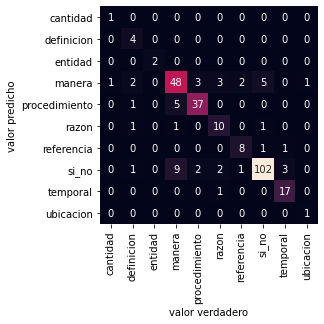

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.44      0.62         9
      entidad       1.00      1.00      1.00         2
       manera       0.74      0.76      0.75        63
procedimiento       0.86      0.88      0.87        42
        razon       0.77      0.62      0.69        16
   referencia       0.80      0.73      0.76        11
        si_no       0.85      0.94      0.89       109
     temporal       0.94      0.81      0.87        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.83       277
    macro avg       0.90      0.72      0.78       277
 weighted avg       0.83      0.83      0.83       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.838
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.852


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.477067,0.092257,0.003125,0.006250,100,{'C': 100},0.833333,0.833333,0.873874,0.828054,0.819005,0.837520,0.018916,1
4,1.772807,0.057506,0.000000,0.000000,10,{'C': 10},0.819820,0.801802,0.828829,0.841629,0.800905,0.818597,0.015695,2
3,1.061410,0.069170,0.003125,0.006250,1,{'C': 1},0.738739,0.716216,0.711712,0.710407,0.710407,0.717496,0.010834,3
2,0.520215,0.036289,0.000000,0.000000,0.1,{'C': 0.1},0.405405,0.405405,0.418919,0.402715,0.398190,0.406127,0.006918,4
0,1.020392,0.145367,0.001401,0.001201,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


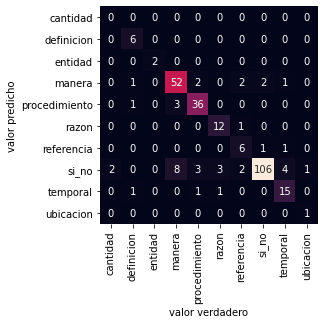

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       1.00      0.67      0.80         9
      entidad       1.00      1.00      1.00         2
       manera       0.87      0.83      0.85        63
procedimiento       0.90      0.86      0.88        42
        razon       0.92      0.75      0.83        16
   referencia       0.75      0.55      0.63        11
        si_no       0.82      0.97      0.89       109
     temporal       0.83      0.71      0.77        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.85       277
    macro avg       0.81      0.68      0.73       277
 weighted avg       0.85      0.85      0.85       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.841
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.841


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.505704,0.030232,0.003378,0.006756,100,{'C': 100},0.846847,0.815315,0.860360,0.855204,0.828054,0.841156,0.016958,1
4,1.095399,0.047896,0.000000,0.000000,10,{'C': 10},0.828829,0.797297,0.837838,0.832579,0.814480,0.822205,0.014669,2
3,0.683789,0.059110,0.000000,0.000000,1,{'C': 1},0.684685,0.680180,0.680180,0.656109,0.674208,0.675072,0.010049,3
2,0.337753,0.016263,0.000000,0.000000,0.1,{'C': 0.1},0.387387,0.387387,0.387387,0.389140,0.393665,0.388994,0.002432,4
0,0.676147,0.039391,0.000000,0.000000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


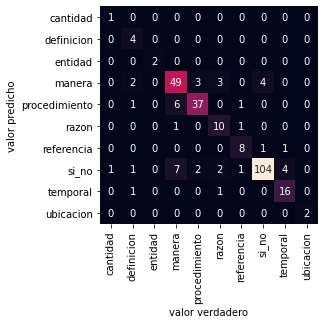

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      0.50      0.67         2
   definicion       1.00      0.44      0.62         9
      entidad       1.00      1.00      1.00         2
       manera       0.80      0.78      0.79        63
procedimiento       0.82      0.88      0.85        42
        razon       0.83      0.62      0.71        16
   referencia       0.80      0.73      0.76        11
        si_no       0.85      0.95      0.90       109
     temporal       0.89      0.76      0.82        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.84       277
    macro avg       0.90      0.77      0.81       277
 weighted avg       0.84      0.84      0.84       277


CARGA DE DATASET: DS1 - TRAINING SET Y TESTING SET

TRAINING SET y TESTING SET: Obtenidos desde el mismo archivo
LECTURA DEL ARCHIVO: DS1_usuario_afip.csv
   IUCA                 

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.986
- Accuracy Score - cross-validation: 0.728
- Mejores parametros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.726


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
76,0.205136,0.002900,0.022815,7.489782e-04,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.716216,0.725225,0.779279,0.733032,0.687783,0.728307,0.029727,1
64,0.201029,0.012099,0.022414,2.060616e-03,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.725225,0.725225,0.765766,0.733032,0.683258,0.726501,0.026297,2
87,0.165846,0.007841,0.015626,5.917394e-07,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.698198,0.747748,0.729730,0.737557,0.692308,0.721108,0.021949,3
88,0.196885,0.007656,0.028355,6.379454e-03,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.702703,0.711712,0.770270,0.728507,0.683258,0.719290,0.029376,4
52,0.197097,0.016024,0.021877,7.654656e-03,2,0.1,rbf,"{'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}",0.711712,0.716216,0.734234,0.723982,0.701357,0.717500,0.011116,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


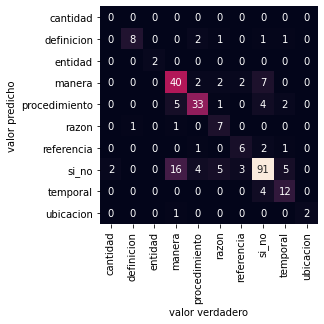

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.62      0.89      0.73         9
      entidad       1.00      1.00      1.00         2
       manera       0.75      0.63      0.69        63
procedimiento       0.73      0.79      0.76        42
        razon       0.78      0.44      0.56        16
   referencia       0.60      0.55      0.57        11
        si_no       0.72      0.83      0.77       109
     temporal       0.75      0.57      0.65        21
    ubicacion       0.67      1.00      0.80         2

     accuracy                           0.73       277
    macro avg       0.66      0.67      0.65       277
 weighted avg       0.72      0.73      0.72       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.952
- Accuracy Score - cross-validation: 0.741
- Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.729


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,0.191356,0.006471,0.017504,3.756404e-03,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.716216,0.734234,0.779279,0.742081,0.733032,0.740969,0.020928,1
76,0.203350,0.000426,0.018961,6.674862e-03,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.720721,0.729730,0.779279,0.742081,0.710407,0.736444,0.023820,2
55,0.140881,0.013702,0.015626,3.568323e-07,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.738739,0.711712,0.747748,0.714932,0.737557,0.730137,0.014212,3
67,0.121882,0.006251,0.015851,4.507310e-04,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.693694,0.734234,0.765766,0.710407,0.687783,0.718377,0.028656,4
54,0.253575,0.011885,0.021876,7.653818e-03,2,1,rbf,"{'C': 2, 'gamma': 1, 'kernel': 'rbf'}",0.711712,0.693694,0.738739,0.733032,0.710407,0.717517,0.016388,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


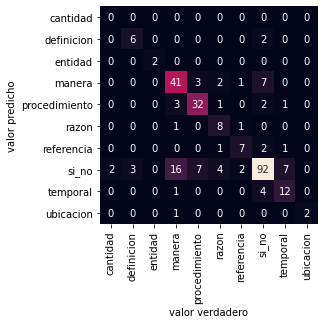

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.75      0.67      0.71         9
      entidad       1.00      1.00      1.00         2
       manera       0.76      0.65      0.70        63
procedimiento       0.82      0.76      0.79        42
        razon       0.80      0.50      0.62        16
   referencia       0.64      0.64      0.64        11
        si_no       0.69      0.84      0.76       109
     temporal       0.71      0.57      0.63        21
    ubicacion       0.67      1.00      0.80         2

     accuracy                           0.73       277
    macro avg       0.68      0.66      0.66       277
 weighted avg       0.73      0.73      0.72       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 5618
Vocabulario: [' 07', ' 07/', ' 12', ' 12 ', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 27%', ' 30', ' 30 ', ' 6 ', ' 6 m']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.99
- Accuracy Score - cross-validation: 0.728
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.733


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,1.264528,0.015523,0.188115,0.009957,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.702703,0.734234,0.743243,0.737557,0.723982,0.728344,0.014269,1
86,1.161154,0.039610,0.181472,0.016231,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.716216,0.747748,0.729730,0.719457,0.719457,0.726522,0.011549,2
76,1.291683,0.045526,0.191802,0.011408,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.738739,0.752252,0.720721,0.696833,0.719457,0.725600,0.018826,3
89,1.139499,0.026611,0.169387,0.011889,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.684685,0.734234,0.734234,0.733032,0.728507,0.722938,0.019243,4
67,0.907865,0.011818,0.178791,0.007151,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.702703,0.738739,0.693694,0.728507,0.701357,0.713000,0.017420,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


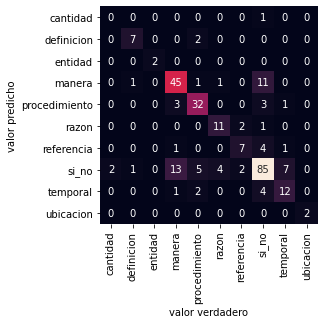

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.78      0.78      0.78         9
      entidad       1.00      1.00      1.00         2
       manera       0.76      0.71      0.74        63
procedimiento       0.82      0.76      0.79        42
        razon       0.79      0.69      0.73        16
   referencia       0.54      0.64      0.58        11
        si_no       0.71      0.78      0.75       109
     temporal       0.63      0.57      0.60        21
    ubicacion       1.00      1.00      1.00         2

     accuracy                           0.73       277
    macro avg       0.70      0.69      0.70       277
 weighted avg       0.73      0.73      0.73       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.98
- Accuracy Score - cross-validation: 0.73
- Mejores parametros: {'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=5, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.736


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.294277,0.005989,0.025001,0.007656,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.729730,0.716216,0.738739,0.746606,0.719457,0.730150,0.011430,1
55,0.266300,0.000884,0.028126,0.006250,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.743243,0.711712,0.734234,0.760181,0.701357,0.730146,0.021255,2
91,0.288747,0.007622,0.025002,0.007655,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.729730,0.707207,0.752252,0.733032,0.701357,0.724716,0.018465,3
79,0.287648,0.010270,0.031471,0.000439,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.729730,0.702703,0.747748,0.728507,0.701357,0.722009,0.017684,4
86,0.336072,0.011974,0.034377,0.006251,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.729730,0.702703,0.729730,0.733032,0.705882,0.720215,0.013095,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


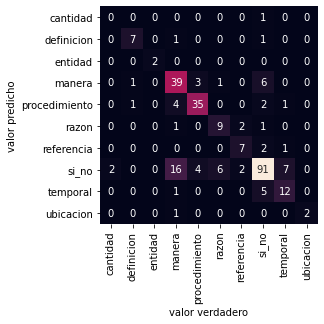

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.78      0.78      0.78         9
      entidad       1.00      1.00      1.00         2
       manera       0.78      0.62      0.69        63
procedimiento       0.81      0.83      0.82        42
        razon       0.69      0.56      0.62        16
   referencia       0.70      0.64      0.67        11
        si_no       0.71      0.83      0.77       109
     temporal       0.67      0.57      0.62        21
    ubicacion       0.67      1.00      0.80         2

     accuracy                           0.74       277
    macro avg       0.68      0.68      0.68       277
 weighted avg       0.74      0.74      0.73       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.985
- Accuracy Score - cross-validation: 0.734
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.704


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.470700,0.030510,0.000208,0.000415,10,{'C': 10},0.716216,0.743243,0.743243,0.737557,0.728507,0.733753,0.010292,1
3,0.275236,0.019015,0.006251,0.007655,1,{'C': 1},0.707207,0.756757,0.720721,0.742081,0.733032,0.731960,0.017073,2
5,0.876805,0.080187,0.000000,0.000000,100,{'C': 100},0.689189,0.743243,0.729730,0.723982,0.692308,0.715690,0.021326,3
2,0.181484,0.007849,0.000000,0.000000,0.1,{'C': 0.1},0.603604,0.608108,0.603604,0.606335,0.615385,0.607407,0.004341,4
1,0.162738,0.012393,0.000000,0.000000,0.01,{'C': 0.01},0.400901,0.396396,0.391892,0.398190,0.389140,0.395304,0.004254,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


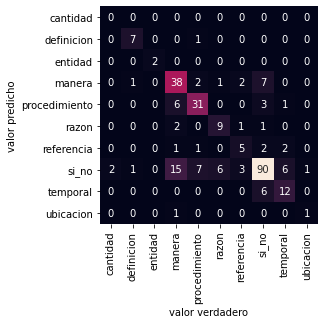

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.88      0.78      0.82         9
      entidad       1.00      1.00      1.00         2
       manera       0.75      0.60      0.67        63
procedimiento       0.76      0.74      0.75        42
        razon       0.69      0.56      0.62        16
   referencia       0.45      0.45      0.45        11
        si_no       0.69      0.83      0.75       109
     temporal       0.67      0.57      0.62        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.70       277
    macro avg       0.64      0.60      0.62       277
 weighted avg       0.70      0.70      0.70       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.977
- Accuracy Score - cross-validation: 0.738
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.736


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.487919,0.020031,0.0000,0.000000,10,{'C': 10},0.711712,0.752252,0.756757,0.755656,0.714932,0.738262,0.020443,1
5,0.858321,0.006836,0.0004,0.000801,100,{'C': 100},0.707207,0.747748,0.738739,0.733032,0.705882,0.726522,0.016978,2
3,0.281689,0.027747,0.0000,0.000000,1,{'C': 1},0.662162,0.653153,0.657658,0.678733,0.683258,0.666993,0.011869,3
2,0.135030,0.007792,0.0000,0.000000,0.1,{'C': 0.1},0.396396,0.400901,0.396396,0.398190,0.393665,0.397110,0.002384,4
0,0.268155,0.031437,0.0000,0.000000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


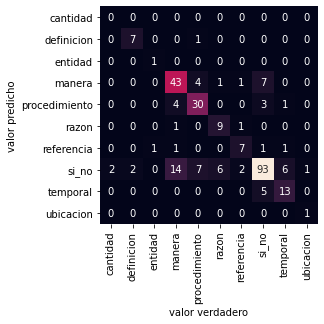

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.88      0.78      0.82         9
      entidad       1.00      0.50      0.67         2
       manera       0.77      0.68      0.72        63
procedimiento       0.79      0.71      0.75        42
        razon       0.82      0.56      0.67        16
   referencia       0.64      0.64      0.64        11
        si_no       0.70      0.85      0.77       109
     temporal       0.72      0.62      0.67        21
    ubicacion       1.00      0.50      0.67         2

     accuracy                           0.74       277
    macro avg       0.73      0.58      0.64       277
 weighted avg       0.74      0.74      0.73       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 5618
Vocabulario: [' 07', ' 07/', ' 12', ' 12 ', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 27%', ' 30', ' 30 ', ' 6 ', ' 6 m']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.99
- Accuracy Score - cross-validation: 0.747
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.736


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.737875,0.128108,0.000000,0.000000,100,{'C': 100},0.716216,0.756757,0.752252,0.755656,0.755656,0.747307,0.015619,1
4,1.813274,0.047681,0.000601,0.000801,10,{'C': 10},0.716216,0.734234,0.743243,0.710407,0.723982,0.725617,0.011894,2
3,0.925995,0.071612,0.000400,0.000801,1,{'C': 1},0.657658,0.662162,0.639640,0.628959,0.647059,0.647096,0.012026,3
2,0.488655,0.040747,0.003126,0.006251,0.1,{'C': 0.1},0.405405,0.400901,0.400901,0.402715,0.389140,0.399812,0.005585,4
0,1.000827,0.078045,0.000600,0.001201,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


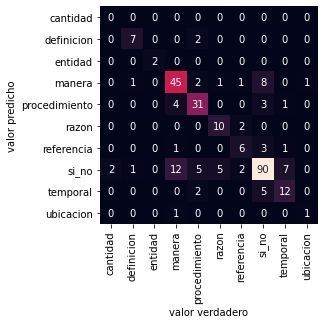

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.78      0.78      0.78         9
      entidad       1.00      1.00      1.00         2
       manera       0.76      0.71      0.74        63
procedimiento       0.79      0.74      0.77        42
        razon       0.83      0.62      0.71        16
   referencia       0.55      0.55      0.55        11
        si_no       0.73      0.83      0.77       109
     temporal       0.63      0.57      0.60        21
    ubicacion       0.50      0.50      0.50         2

     accuracy                           0.74       277
    macro avg       0.66      0.63      0.64       277
 weighted avg       0.73      0.74      0.73       277


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.99
- Accuracy Score - cross-validation: 0.729
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.747


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.597484,0.067481,0.003125,0.006250,100,{'C': 100},0.729730,0.711712,0.738739,0.751131,0.714932,0.729249,0.014708,1
4,1.148883,0.084483,0.000000,0.000000,10,{'C': 10},0.689189,0.680180,0.720721,0.714932,0.701357,0.701276,0.015203,2
3,0.610727,0.034754,0.009375,0.007655,1,{'C': 1},0.612613,0.576577,0.576577,0.597285,0.583710,0.589352,0.013873,3
0,0.645884,0.084138,0.000000,0.000000,0.001,{'C': 0.001},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,4
1,0.269297,0.011691,0.000000,0.000000,0.01,{'C': 0.01},0.387387,0.387387,0.387387,0.389140,0.389140,0.388089,0.000859,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


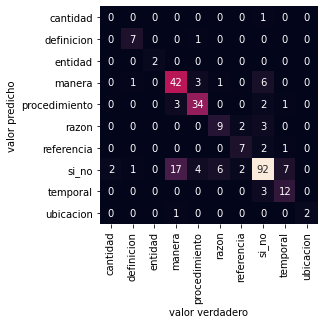

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         2
   definicion       0.88      0.78      0.82         9
      entidad       1.00      1.00      1.00         2
       manera       0.79      0.67      0.72        63
procedimiento       0.85      0.81      0.83        42
        razon       0.64      0.56      0.60        16
   referencia       0.70      0.64      0.67        11
        si_no       0.70      0.84      0.77       109
     temporal       0.80      0.57      0.67        21
    ubicacion       0.67      1.00      0.80         2

     accuracy                           0.75       277
    macro avg       0.70      0.69      0.69       277
 weighted avg       0.75      0.75      0.74       277


FIN DE EXPERIMENTO SOBRE DATASET:  DS1

INICIO EXPERIMENTO SOBRE DATASET:  DS2

CARGA DE DATASET: DS2 - TRAINING SET Y TESTING SET

TRAINING SET Y TESTING SET: Obtenidos de distin

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.814
- Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.901


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,0.200433,0.015616,0.031251,0.000001,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.877551,0.787755,0.800000,0.803279,0.803279,0.814373,0.032102,1
74,0.203345,0.021803,0.037501,0.007655,10,0.01,rbf,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.824490,0.791837,0.795918,0.819672,0.811475,0.808678,0.012846,2
84,0.197118,0.018639,0.034804,0.006055,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.816327,0.787755,0.783673,0.807377,0.823770,0.803781,0.015691,3
87,0.187746,0.017551,0.034377,0.011693,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.828571,0.787755,0.800000,0.786885,0.803279,0.801298,0.015104,4
64,0.360053,0.017158,0.043751,0.011694,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.824490,0.767347,0.771429,0.799180,0.762295,0.784948,0.023545,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


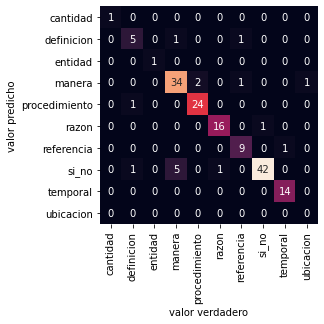

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       0.71      0.71      0.71         7
      entidad       1.00      1.00      1.00         1
       manera       0.89      0.85      0.87        40
procedimiento       0.96      0.92      0.94        26
        razon       0.94      0.94      0.94        17
   referencia       0.90      0.82      0.86        11
        si_no       0.86      0.98      0.91        43
     temporal       1.00      0.93      0.97        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.90       162
    macro avg       0.83      0.82      0.82       162
 weighted avg       0.90      0.90      0.90       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.842
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.926


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,0.262939,0.018306,0.034376,6.250334e-03,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.848980,0.848980,0.816327,0.815574,0.881148,0.842201,0.024443,1
89,0.242570,0.008166,0.037502,7.654480e-03,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.853061,0.848980,0.804082,0.799180,0.877049,0.836470,0.030060,2
55,0.203352,0.019424,0.031250,6.468134e-07,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.848980,0.816327,0.816327,0.811475,0.885246,0.835671,0.028173,3
86,0.272355,0.025711,0.043976,6.375778e-03,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.848980,0.820408,0.816327,0.819672,0.868852,0.834848,0.020678,4
76,0.293975,0.015358,0.040628,7.654539e-03,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.848980,0.812245,0.820408,0.819672,0.864754,0.833212,0.020151,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


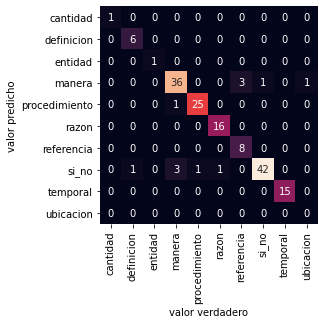

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.86      0.92         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.90      0.89        40
procedimiento       0.96      0.96      0.96        26
        razon       1.00      0.94      0.97        17
   referencia       1.00      0.73      0.84        11
        si_no       0.88      0.98      0.92        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.93       162
    macro avg       0.87      0.84      0.85       162
 weighted avg       0.92      0.93      0.92       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 6351
Vocabulario: [' 07', ' 07 ', ' 072', ' 12', ' 12 ', ' 1e', ' 1er', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 3 ', ' 3 a']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.845
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.901


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,1.840273,0.033547,0.291352,0.020890,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.836735,0.828571,0.848980,0.831967,0.877049,0.844660,0.017610,1
88,1.934938,0.051055,0.290855,0.021264,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.848980,0.828571,0.848980,0.827869,0.864754,0.843831,0.013989,2
76,1.987994,0.114260,0.309877,0.032147,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.836735,0.832653,0.832653,0.823770,0.848361,0.834834,0.007981,3
86,1.878100,0.086784,0.309847,0.015413,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.836735,0.840816,0.828571,0.823770,0.844262,0.834831,0.007615,4
67,1.245563,0.040552,0.263199,0.011280,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.836735,0.804082,0.820408,0.819672,0.860656,0.828310,0.019190,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


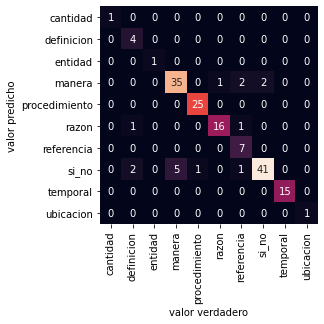

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.57      0.73         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.88      0.88        40
procedimiento       1.00      0.96      0.98        26
        razon       0.89      0.94      0.91        17
   referencia       1.00      0.64      0.78        11
        si_no       0.82      0.95      0.88        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.90       162
    macro avg       0.96      0.89      0.92       162
 weighted avg       0.91      0.90      0.90       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.993
- Accuracy Score - cross-validation: 0.833
- Mejores parametros: {'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=5, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.938


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.472553,0.017731,0.056254,0.007656,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.840816,0.824490,0.836735,0.823770,0.840164,0.833195,0.007534,1
91,0.450873,0.033566,0.062503,0.000002,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.832653,0.824490,0.836735,0.815574,0.836066,0.829103,0.008045,2
79,0.487169,0.010947,0.061626,0.002330,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.828571,0.816327,0.828571,0.827869,0.836066,0.827481,0.006335,3
89,0.607011,0.015485,0.058993,0.006081,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.844898,0.800000,0.832653,0.819672,0.840164,0.827477,0.016169,4
88,0.635829,0.017237,0.068196,0.007028,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.844898,0.804082,0.824490,0.815574,0.836066,0.825022,0.014457,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


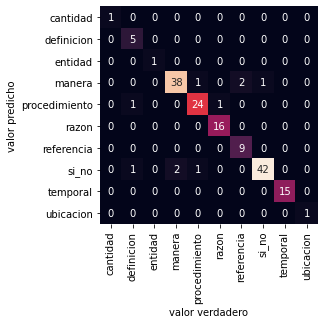

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.95      0.93        40
procedimiento       0.92      0.92      0.92        26
        razon       1.00      0.94      0.97        17
   referencia       1.00      0.82      0.90        11
        si_no       0.91      0.98      0.94        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.94       162
    macro avg       0.97      0.93      0.95       162
 weighted avg       0.94      0.94      0.94       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.832
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.901


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.624225,0.015802,0.003125,0.006250,10,{'C': 10},0.857143,0.820408,0.791837,0.831967,0.860656,0.832402,0.025298,1
5,0.741789,0.018773,0.003125,0.006250,100,{'C': 100},0.861224,0.820408,0.795918,0.819672,0.840164,0.827477,0.021939,2
3,0.422365,0.024515,0.000000,0.000000,1,{'C': 1},0.844898,0.787755,0.783673,0.807377,0.852459,0.815233,0.028561,3
2,0.297755,0.014239,0.000000,0.000000,0.1,{'C': 0.1},0.738776,0.714286,0.689796,0.721311,0.729508,0.718735,0.016623,4
1,0.247358,0.023352,0.003125,0.006251,0.01,{'C': 0.01},0.481633,0.489796,0.457143,0.475410,0.442623,0.469321,0.017140,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


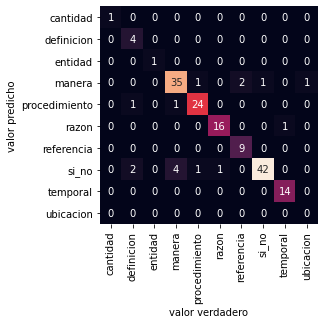

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.57      0.73         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.88      0.88        40
procedimiento       0.92      0.92      0.92        26
        razon       0.94      0.94      0.94        17
   referencia       1.00      0.82      0.90        11
        si_no       0.84      0.98      0.90        43
     temporal       1.00      0.93      0.97        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.90       162
    macro avg       0.86      0.80      0.82       162
 weighted avg       0.90      0.90      0.90       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.835
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.926


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.707825,0.017019,0.000000,0.00000,100,{'C': 100},0.853061,0.820408,0.832653,0.815574,0.852459,0.834831,0.015663,1
4,0.503635,0.012400,0.000000,0.00000,10,{'C': 10},0.844898,0.804082,0.824490,0.803279,0.856557,0.826661,0.021390,2
3,0.300839,0.005912,0.003125,0.00625,1,{'C': 1},0.734694,0.742857,0.751020,0.713115,0.754098,0.739157,0.014668,3
2,0.159620,0.015268,0.003125,0.00625,0.1,{'C': 0.1},0.424490,0.428571,0.428571,0.438525,0.413934,0.426818,0.007932,4
0,0.265855,0.027833,0.003125,0.00625,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


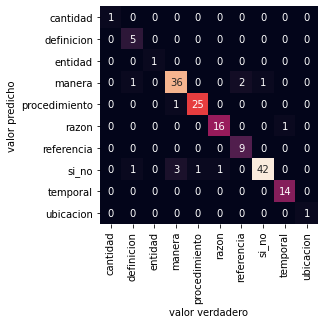

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.90      0.90        40
procedimiento       0.96      0.96      0.96        26
        razon       0.94      0.94      0.94        17
   referencia       1.00      0.82      0.90        11
        si_no       0.88      0.98      0.92        43
     temporal       1.00      0.93      0.97        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.93       162
    macro avg       0.97      0.92      0.94       162
 weighted avg       0.93      0.93      0.93       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.841
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.926


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.979130,0.063475,0.000000,0.00000,100,{'C': 100},0.848980,0.832653,0.840816,0.823770,0.856557,0.840555,0.011587,1
4,2.032007,0.067429,0.003125,0.00625,10,{'C': 10},0.832653,0.812245,0.840816,0.803279,0.836066,0.825012,0.014599,2
3,1.098929,0.020971,0.003125,0.00625,1,{'C': 1},0.726531,0.730612,0.706122,0.692623,0.725410,0.716260,0.014537,3
2,0.566318,0.052433,0.000000,0.00000,0.1,{'C': 0.1},0.412245,0.420408,0.428571,0.422131,0.418033,0.420278,0.005325,4
0,1.095783,0.130894,0.000000,0.00000,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


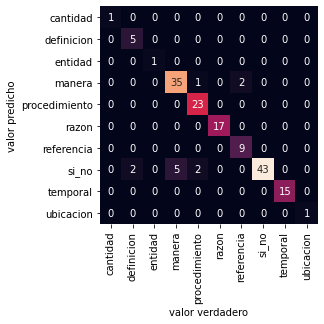

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.92      0.88      0.90        40
procedimiento       1.00      0.88      0.94        26
        razon       1.00      1.00      1.00        17
   referencia       1.00      0.82      0.90        11
        si_no       0.83      1.00      0.91        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.93       162
    macro avg       0.97      0.93      0.95       162
 weighted avg       0.93      0.93      0.93       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.82
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.944


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.931361,0.042342,0.000200,0.000400,100,{'C': 100},0.840816,0.804082,0.832653,0.811475,0.811475,0.820100,0.014086,1
4,1.332288,0.065948,0.003125,0.006250,10,{'C': 10},0.824490,0.791837,0.795918,0.811475,0.803279,0.805400,0.011659,2
3,0.771803,0.044535,0.003125,0.006250,1,{'C': 1},0.685714,0.697959,0.677551,0.663934,0.692623,0.683556,0.011961,3
0,0.685614,0.039524,0.006250,0.007655,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,4
1,0.344213,0.028334,0.003125,0.006250,0.01,{'C': 0.01},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


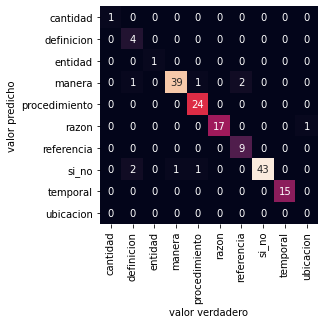

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.57      0.73         7
      entidad       1.00      1.00      1.00         1
       manera       0.91      0.97      0.94        40
procedimiento       1.00      0.92      0.96        26
        razon       0.94      1.00      0.97        17
   referencia       1.00      0.82      0.90        11
        si_no       0.91      1.00      0.96        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.94       162
    macro avg       0.88      0.83      0.85       162
 weighted avg       0.94      0.94      0.94       162


CARGA DE DATASET: DS2 - TRAINING SET Y TESTING SET

TRAINING SET Y TESTING SET: Obtenidos de distintos archivos
TRAINING SET:
LECTURA DEL ARCHIVO: DS2-train_usuario.csv
   IUCA   

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Datos procesados:
debe cumplir proceder recategorizacion oficio
diferencia unidad explotacion actividad economica
cambio domicilio realiza online
sacar alguien obra social debo hacer
actividades excluidas monotributo
...

FIN DE PREPROCESAMIENTO - DS2

DS2 - PREPROCESAMIENTO TESTING SET - TIPO: BASELINE_STOPWORD_SINFILTRO

Datos a procesar:
¿Cómo se modifica la situación frente al Monotributo en caso de realizar aportes obligatorios a una caja previsional provincial?
Respecto del componente previsional (jubilación y obra social), ¿se puede abonar solo uno de dichos conceptos y excluir del pago el otro?
¿Quiénes se encuentran obligados a emitir comprobantes de forma manual?
¿En qué casos se produce la baja automática en el Monotributo?
Pasos para adherirse mediante el portal de Monotributo.
...
Datos procesados:
modifica situacion frente monotributo caso realizar aportes obligatorios caja previsional provincial
respecto componente previsional jubilacion obra social puede abonar solo dic

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.977
- Accuracy Score - cross-validation: 0.723
- Mejores parametros: {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=5, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.84


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
64,0.244728,0.008064,0.031480,0.000455,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.734694,0.718367,0.722449,0.700820,0.737705,0.722807,0.013165,1
76,0.228351,0.015814,0.028335,0.006369,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.710204,0.710204,0.702041,0.709016,0.733607,0.713014,0.010735,2
88,0.200221,0.018444,0.021876,0.007655,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.714286,0.697959,0.677551,0.696721,0.737705,0.704844,0.020136,3
87,0.165847,0.018468,0.018752,0.006249,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.693878,0.697959,0.681633,0.680328,0.725410,0.695841,0.016280,4
86,0.181965,0.007774,0.021876,0.007655,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.697959,0.693878,0.673469,0.684426,0.721311,0.694209,0.015966,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


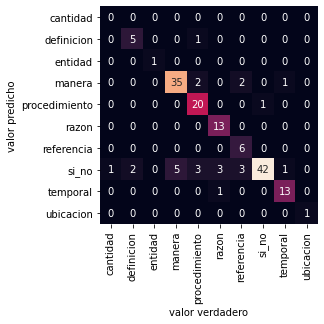

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.83      0.71      0.77         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.88      0.88        40
procedimiento       0.95      0.77      0.85        26
        razon       1.00      0.76      0.87        17
   referencia       1.00      0.55      0.71        11
        si_no       0.70      0.98      0.82        43
     temporal       0.93      0.87      0.90        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.84       162
    macro avg       0.83      0.75      0.78       162
 weighted avg       0.86      0.84      0.84       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.944
- Accuracy Score - cross-validation: 0.715
- Mejores parametros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.846


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
76,0.210567,0.012985,0.023434,0.009574,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.706122,0.693878,0.710204,0.704918,0.758197,0.714664,0.022428,1
86,0.228849,0.008639,0.029203,0.007166,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.702041,0.685714,0.710204,0.717213,0.754098,0.713854,0.022696,2
55,0.159599,0.011352,0.018750,0.006250,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.714286,0.677551,0.710204,0.692623,0.770492,0.713031,0.031580,3
67,0.156469,0.009551,0.018752,0.006250,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.706122,0.697959,0.689796,0.684426,0.754098,0.706480,0.024920,4
88,0.235957,0.006149,0.026817,0.000401,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.685714,0.681633,0.681633,0.721311,0.725410,0.699140,0.019874,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


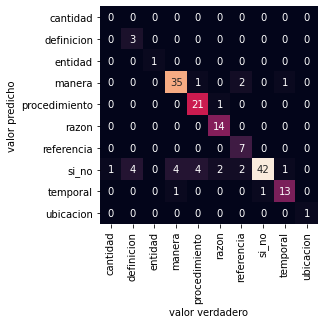

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       1.00      0.43      0.60         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.88      0.89        40
procedimiento       0.95      0.81      0.88        26
        razon       1.00      0.82      0.90        17
   referencia       1.00      0.64      0.78        11
        si_no       0.70      0.98      0.82        43
     temporal       0.87      0.87      0.87        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.85       162
    macro avg       0.84      0.74      0.77       162
 weighted avg       0.87      0.85      0.84       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 5761
Vocabulario: [' 07', ' 07 ', ' 072', ' 12', ' 12 ', ' 1e', ' 1er', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 3 ', ' 3 a']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.945
- Accuracy Score - cross-validation: 0.715
- Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.846


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,1.367453,0.065146,0.233082,0.010276,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.689796,0.697959,0.722449,0.729508,0.737705,0.715483,0.018471,1
76,1.409718,0.067814,0.222581,0.011859,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.693878,0.689796,0.722449,0.713115,0.741803,0.712208,0.019078,2
88,1.571962,0.041637,0.236653,0.005931,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.677551,0.677551,0.702041,0.713115,0.729508,0.699953,0.020272,3
89,1.487006,0.079815,0.236357,0.013535,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.677551,0.689796,0.693878,0.700820,0.737705,0.699950,0.020337,4
55,1.105267,0.032147,0.205690,0.007574,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.677551,0.681633,0.702041,0.700820,0.733607,0.699130,0.019858,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


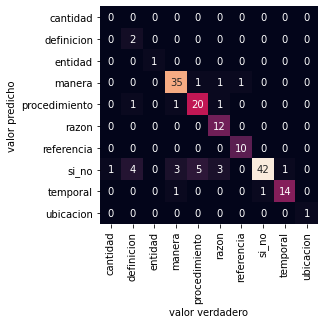

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       1.00      0.29      0.44         7
      entidad       1.00      1.00      1.00         1
       manera       0.92      0.88      0.90        40
procedimiento       0.87      0.77      0.82        26
        razon       1.00      0.71      0.83        17
   referencia       1.00      0.91      0.95        11
        si_no       0.71      0.98      0.82        43
     temporal       0.88      0.93      0.90        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.85       162
    macro avg       0.84      0.75      0.77       162
 weighted avg       0.87      0.85      0.84       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.976
- Accuracy Score - cross-validation: 0.713
- Mejores parametros: {'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=5, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.846


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.341427,0.006341,0.031420,0.001357,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.702041,0.710204,0.726531,0.696721,0.729508,0.713001,0.013027,1
79,0.357436,0.013696,0.032623,0.002061,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.702041,0.706122,0.722449,0.692623,0.721311,0.708909,0.011466,2
89,0.384054,0.007114,0.033423,0.002060,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.702041,0.714286,0.693878,0.709016,0.717213,0.707287,0.008460,3
55,0.350833,0.013011,0.033422,0.001626,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.706122,0.710204,0.697959,0.713115,0.704918,0.706464,0.005159,4
91,0.334622,0.008964,0.031020,0.001416,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.710204,0.702041,0.702041,0.688525,0.717213,0.704005,0.009594,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


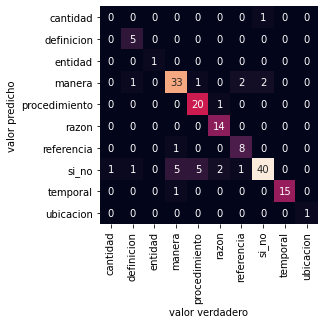

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.85      0.82      0.84        40
procedimiento       0.95      0.77      0.85        26
        razon       1.00      0.82      0.90        17
   referencia       0.89      0.73      0.80        11
        si_no       0.73      0.93      0.82        43
     temporal       0.94      1.00      0.97        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.85       162
    macro avg       0.84      0.78      0.80       162
 weighted avg       0.86      0.85      0.85       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.984
- Accuracy Score - cross-validation: 0.708
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.852


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.466310,0.024306,0.000599,4.894732e-04,10,{'C': 10},0.714286,0.689796,0.685714,0.709016,0.741803,0.708123,0.020056,1
3,0.244162,0.012970,0.000800,4.000427e-04,1,{'C': 1},0.697959,0.681633,0.693878,0.700820,0.745902,0.704038,0.021932,2
5,0.850164,0.037370,0.000600,4.899793e-04,100,{'C': 100},0.689796,0.677551,0.673469,0.680328,0.704918,0.685212,0.011223,3
2,0.149099,0.008005,0.001000,2.861023e-07,0.1,{'C': 0.1},0.628571,0.612245,0.600000,0.594262,0.618852,0.610786,0.012433,4
1,0.128486,0.010714,0.001000,6.328628e-04,0.01,{'C': 0.01},0.408163,0.420408,0.404082,0.409836,0.405738,0.409645,0.005732,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


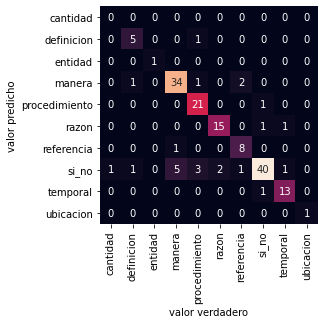

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.83      0.71      0.77         7
      entidad       1.00      1.00      1.00         1
       manera       0.89      0.85      0.87        40
procedimiento       0.95      0.81      0.88        26
        razon       0.88      0.88      0.88        17
   referencia       0.89      0.73      0.80        11
        si_no       0.74      0.93      0.82        43
     temporal       0.93      0.87      0.90        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.85       162
    macro avg       0.81      0.78      0.79       162
 weighted avg       0.86      0.85      0.85       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.971
- Accuracy Score - cross-validation: 0.717
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.846


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.493328,0.013821,0.001000,7.629395e-07,10,{'C': 10},0.710204,0.669388,0.714286,0.729508,0.762295,0.717136,0.030095,1
5,0.855567,0.017595,0.000600,4.899800e-04,100,{'C': 100},0.702041,0.677551,0.706122,0.704918,0.737705,0.705667,0.019136,2
3,0.261574,0.007766,0.001200,4.002572e-04,1,{'C': 1},0.665306,0.669388,0.620408,0.635246,0.676230,0.653315,0.021617,3
2,0.130087,0.011304,0.000799,3.997092e-04,0.1,{'C': 0.1},0.408163,0.412245,0.408163,0.422131,0.409836,0.412108,0.005230,4
0,0.239960,0.010785,0.000600,4.895512e-04,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


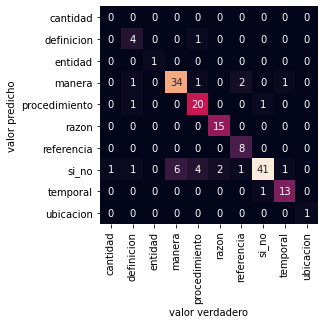

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.80      0.57      0.67         7
      entidad       1.00      1.00      1.00         1
       manera       0.87      0.85      0.86        40
procedimiento       0.91      0.77      0.83        26
        razon       1.00      0.88      0.94        17
   referencia       1.00      0.73      0.84        11
        si_no       0.72      0.95      0.82        43
     temporal       0.93      0.87      0.90        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.85       162
    macro avg       0.82      0.76      0.79       162
 weighted avg       0.86      0.85      0.84       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 5761
Vocabulario: [' 07', ' 07 ', ' 072', ' 12', ' 12 ', ' 1e', ' 1er', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 3 ', ' 3 a']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.989
- Accuracy Score - cross-validation: 0.709
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.827


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,3.090048,0.038408,0.001402,4.905439e-04,100,{'C': 100},0.689796,0.677551,0.718367,0.721311,0.737705,0.708946,0.022005,1
4,1.873042,0.083370,0.001802,4.000436e-04,10,{'C': 10},0.673469,0.693878,0.718367,0.709016,0.729508,0.704848,0.019561,2
3,0.940823,0.039102,0.001601,4.902908e-04,1,{'C': 1},0.636735,0.657143,0.620408,0.622951,0.655738,0.638595,0.015600,3
2,0.487723,0.029689,0.002001,4.909339e-07,0.1,{'C': 0.1},0.408163,0.420408,0.420408,0.422131,0.409836,0.416189,0.005928,4
0,0.777315,0.101468,0.002002,2.780415e-07,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


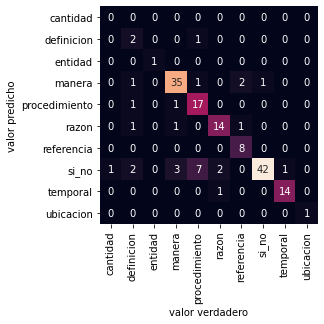

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.67      0.29      0.40         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.88      0.88        40
procedimiento       0.89      0.65      0.76        26
        razon       0.82      0.82      0.82        17
   referencia       1.00      0.73      0.84        11
        si_no       0.72      0.98      0.83        43
     temporal       0.93      0.93      0.93        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.83       162
    macro avg       0.79      0.73      0.75       162
 weighted avg       0.83      0.83      0.82       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.989
- Accuracy Score - cross-validation: 0.705
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.864


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.766370,0.063532,0.001402,0.000490,100,{'C': 100},0.702041,0.702041,0.681633,0.709016,0.729508,0.704848,0.015364,1
4,1.274366,0.026545,0.001701,0.000401,10,{'C': 10},0.693878,0.697959,0.673469,0.692623,0.713115,0.694209,0.012683,2
3,0.651738,0.054222,0.001202,0.000401,1,{'C': 1},0.595918,0.608163,0.583673,0.598361,0.598361,0.596895,0.007836,3
0,0.540158,0.035635,0.001401,0.000490,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,4
1,0.265776,0.014329,0.001202,0.000400,0.01,{'C': 0.01},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


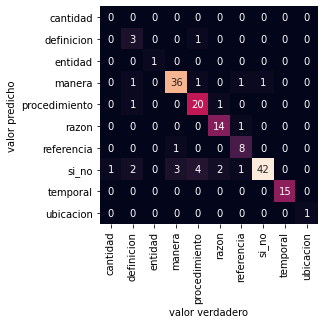

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.75      0.43      0.55         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.90      0.90        40
procedimiento       0.91      0.77      0.83        26
        razon       0.93      0.82      0.87        17
   referencia       0.89      0.73      0.80        11
        si_no       0.76      0.98      0.86        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.86       162
    macro avg       0.81      0.76      0.78       162
 weighted avg       0.87      0.86      0.86       162


CARGA DE DATASET: DS2 - TRAINING SET Y TESTING SET

TRAINING SET Y TESTING SET: Obtenidos de distintos archivos
TRAINING SET:
LECTURA DEL ARCHIVO: DS2-train_usuario.csv
   IUCA   

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Datos procesados:
que debe cumplir para proceder recategorizacion oficio
cual es diferencia entre unidad explotacion actividad economica
cambio domicilio realiza online
para sacar alguien obra social que debo hacer
hay actividades que excluidas monotributo
...

FIN DE PREPROCESAMIENTO - DS2

DS2 - PREPROCESAMIENTO TESTING SET - TIPO: BASELINE_STOPWORD_CONFILTRO

Datos a procesar:
¿Cómo se modifica la situación frente al Monotributo en caso de realizar aportes obligatorios a una caja previsional provincial?
Respecto del componente previsional (jubilación y obra social), ¿se puede abonar solo uno de dichos conceptos y excluir del pago el otro?
¿Quiénes se encuentran obligados a emitir comprobantes de forma manual?
¿En qué casos se produce la baja automática en el Monotributo?
Pasos para adherirse mediante el portal de Monotributo.
...
Datos procesados:
como modifica situacion frente monotributo caso realizar aportes obligatorios caja previsional provincial
respecto componente previsional

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.834
- Mejores parametros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.895


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
76,0.265276,0.007093,0.032721,0.001436,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.836735,0.820408,0.824490,0.836066,0.852459,0.834031,0.011204,1
88,0.274982,0.004425,0.033222,0.000679,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.836735,0.820408,0.824490,0.827869,0.852459,0.832392,0.011385,2
64,0.264976,0.005666,0.031421,0.001068,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.848980,0.816327,0.820408,0.823770,0.848361,0.831569,0.014162,3
86,0.191126,0.005792,0.029720,0.000748,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.840816,0.812245,0.804082,0.807377,0.852459,0.823396,0.019504,4
87,0.184922,0.004898,0.026718,0.000679,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.844898,0.795918,0.808163,0.786885,0.844262,0.816025,0.024274,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


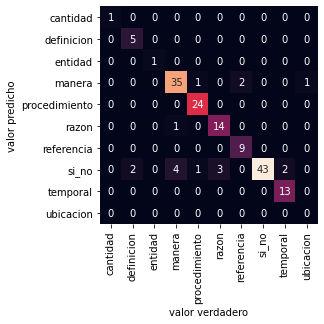

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.88      0.89        40
procedimiento       1.00      0.92      0.96        26
        razon       0.93      0.82      0.87        17
   referencia       1.00      0.82      0.90        11
        si_no       0.78      1.00      0.88        43
     temporal       1.00      0.87      0.93        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.90       162
    macro avg       0.86      0.80      0.83       162
 weighted avg       0.90      0.90      0.89       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.997
- Accuracy Score - cross-validation: 0.828
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.938


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,0.201634,0.004542,0.027218,0.000981,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.816327,0.828571,0.816327,0.811475,0.868852,0.828310,0.021045,1
88,0.218745,0.009689,0.031421,0.001069,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.812245,0.836735,0.824490,0.803279,0.864754,0.828300,0.021440,2
86,0.214443,0.005195,0.030220,0.000510,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.832653,0.804082,0.832653,0.811475,0.836066,0.823386,0.013016,3
76,0.223949,0.005394,0.031321,0.000510,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.836735,0.804082,0.824490,0.807377,0.836066,0.821750,0.013826,4
55,0.171713,0.004032,0.026318,0.000813,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.820408,0.791837,0.816327,0.827869,0.848361,0.820960,0.018267,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


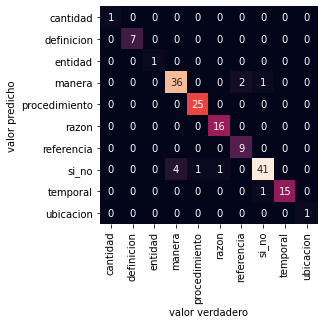

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      1.00      1.00         7
      entidad       1.00      1.00      1.00         1
       manera       0.92      0.90      0.91        40
procedimiento       1.00      0.96      0.98        26
        razon       1.00      0.94      0.97        17
   referencia       1.00      0.82      0.90        11
        si_no       0.87      0.95      0.91        43
     temporal       0.94      1.00      0.97        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.94       162
    macro avg       0.97      0.96      0.96       162
 weighted avg       0.94      0.94      0.94       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.836
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.926


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,1.795089,0.022412,0.284889,0.006318,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.840816,0.816327,0.832653,0.831967,0.856557,0.835664,0.013113,1
89,1.658099,0.024771,0.263575,0.003802,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.848980,0.812245,0.824490,0.827869,0.852459,0.833208,0.015253,2
86,1.638086,0.008342,0.282787,0.004937,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.836735,0.832653,0.828571,0.807377,0.860656,0.833198,0.017058,3
76,1.768071,0.045544,0.291794,0.004834,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.824490,0.828571,0.832653,0.815574,0.848361,0.829930,0.010813,4
67,1.140756,0.014467,0.238358,0.005244,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.812245,0.828571,0.800000,0.823770,0.856557,0.824229,0.018947,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


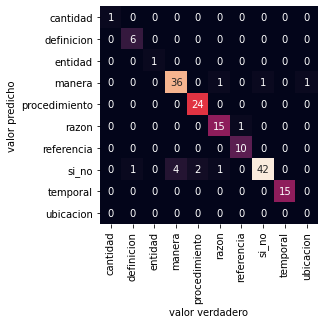

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.86      0.92         7
      entidad       1.00      1.00      1.00         1
       manera       0.92      0.90      0.91        40
procedimiento       1.00      0.92      0.96        26
        razon       0.94      0.88      0.91        17
   referencia       1.00      0.91      0.95        11
        si_no       0.84      0.98      0.90        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.93       162
    macro avg       0.87      0.84      0.86       162
 weighted avg       0.93      0.93      0.92       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.985
- Accuracy Score - cross-validation: 0.83
- Mejores parametros: {'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=2, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.944


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
55,0.421051,0.010517,0.044729,0.001991,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.844898,0.820408,0.836735,0.823770,0.823770,0.829916,0.009348,1
91,0.403267,0.020866,0.043028,0.000634,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.848980,0.820408,0.824490,0.823770,0.827869,0.829103,0.010217,2
79,0.439691,0.016402,0.045631,0.001627,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.844898,0.828571,0.828571,0.819672,0.819672,0.828277,0.009214,3
67,0.430086,0.016313,0.043028,0.002371,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.848980,0.820408,0.828571,0.819672,0.819672,0.827461,0.011273,4
89,0.482320,0.012831,0.045230,0.002228,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.836735,0.820408,0.836735,0.819672,0.819672,0.826644,0.008243,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


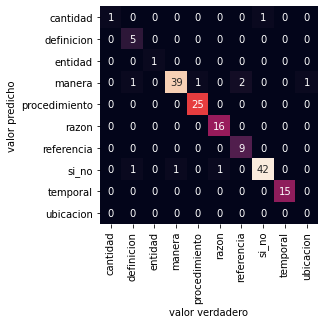

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.50      1.00      0.67         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.89      0.97      0.93        40
procedimiento       1.00      0.96      0.98        26
        razon       1.00      0.94      0.97        17
   referencia       1.00      0.82      0.90        11
        si_no       0.93      0.98      0.95        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.94       162
    macro avg       0.83      0.84      0.82       162
 weighted avg       0.94      0.94      0.94       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.829
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.87


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.488324,0.014473,0.001000,0.000633,10,{'C': 10},0.861224,0.812245,0.779592,0.831967,0.860656,0.829137,0.030890,1
5,0.670846,0.008314,0.001199,0.000399,100,{'C': 100},0.865306,0.808163,0.787755,0.819672,0.844262,0.825032,0.027183,2
3,0.304803,0.018074,0.001000,0.000001,1,{'C': 1},0.824490,0.775510,0.787755,0.803279,0.848361,0.807879,0.026033,3
2,0.210941,0.013986,0.001000,0.000001,0.1,{'C': 0.1},0.759184,0.685714,0.710204,0.684426,0.733607,0.714627,0.028681,4
1,0.189126,0.006787,0.001000,0.000001,0.01,{'C': 0.01},0.473469,0.477551,0.428571,0.467213,0.438525,0.457066,0.019735,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


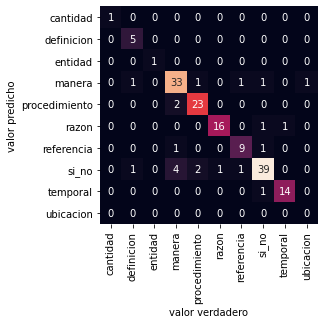

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.87      0.82      0.85        40
procedimiento       0.92      0.88      0.90        26
        razon       0.89      0.94      0.91        17
   referencia       0.82      0.82      0.82        11
        si_no       0.81      0.91      0.86        43
     temporal       0.93      0.93      0.93        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.87       162
    macro avg       0.82      0.80      0.81       162
 weighted avg       0.87      0.87      0.87       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.829
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.907


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.791724,0.007787,0.001000,9.956652e-07,100,{'C': 100},0.824490,0.816327,0.812245,0.823770,0.868852,0.829137,0.020382,1
4,0.539758,0.020590,0.001201,4.011397e-04,10,{'C': 10},0.828571,0.791837,0.812245,0.811475,0.856557,0.820137,0.021614,2
3,0.287791,0.008434,0.001000,9.725608e-07,1,{'C': 1},0.755102,0.714286,0.746939,0.700820,0.770492,0.737528,0.025968,3
2,0.151101,0.008679,0.001401,4.910949e-04,0.1,{'C': 0.1},0.432653,0.420408,0.432653,0.446721,0.418033,0.430094,0.010284,4
0,0.277585,0.020079,0.000999,6.106495e-07,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


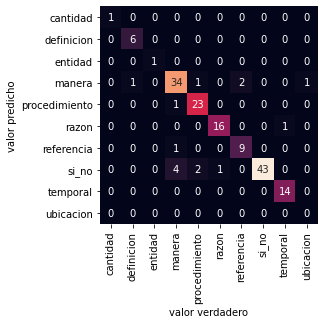

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.86      0.92         7
      entidad       1.00      1.00      1.00         1
       manera       0.87      0.85      0.86        40
procedimiento       0.96      0.88      0.92        26
        razon       0.94      0.94      0.94        17
   referencia       0.90      0.82      0.86        11
        si_no       0.86      1.00      0.92        43
     temporal       1.00      0.93      0.97        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.91       162
    macro avg       0.85      0.83      0.84       162
 weighted avg       0.91      0.91      0.90       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 5958
Vocabulario: [' 07', ' 07 ', ' 072', ' 12', ' 12 ', ' 1e', ' 1er', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 3 ', ' 3 a']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.842
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.914


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.915331,0.129542,0.002002,6.321836e-04,100,{'C': 100},0.844898,0.844898,0.853061,0.811475,0.856557,0.842178,0.016017,1
4,1.998725,0.106313,0.002001,6.324118e-04,10,{'C': 10},0.820408,0.820408,0.832653,0.807377,0.827869,0.821743,0.008562,2
3,1.085119,0.058092,0.002001,6.330135e-04,1,{'C': 1},0.738776,0.726531,0.710204,0.700820,0.758197,0.726905,0.020394,3
2,0.580385,0.039630,0.002202,4.004005e-04,0.1,{'C': 0.1},0.416327,0.416327,0.432653,0.413934,0.409836,0.417815,0.007789,4
0,0.935820,0.076731,0.002003,8.064048e-07,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


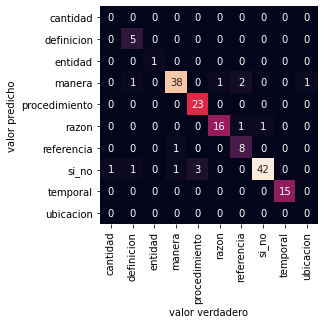

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.95      0.92        40
procedimiento       1.00      0.88      0.94        26
        razon       0.89      0.94      0.91        17
   referencia       0.89      0.73      0.80        11
        si_no       0.88      0.98      0.92        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.91       162
    macro avg       0.75      0.72      0.73       162
 weighted avg       0.91      0.91      0.91       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.823
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.932


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.792298,0.092146,0.001401,0.000491,100,{'C': 100},0.836735,0.800000,0.828571,0.815574,0.836066,0.823389,0.013956,1
4,1.341074,0.082397,0.001401,0.000490,10,{'C': 10},0.808163,0.779592,0.808163,0.795082,0.815574,0.801315,0.012711,2
3,0.725080,0.051643,0.001602,0.000491,1,{'C': 1},0.697959,0.685714,0.702041,0.659836,0.684426,0.685995,0.014747,3
2,0.387256,0.020990,0.001202,0.000400,0.1,{'C': 0.1},0.404082,0.408163,0.404082,0.405738,0.409836,0.406380,0.002285,4
0,0.730884,0.065925,0.002202,0.000400,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


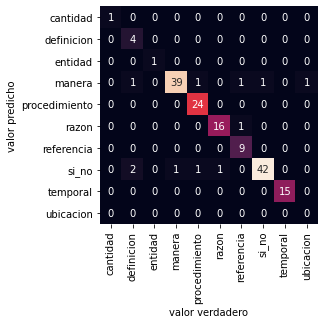

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.57      0.73         7
      entidad       1.00      1.00      1.00         1
       manera       0.89      0.97      0.93        40
procedimiento       1.00      0.92      0.96        26
        razon       0.94      0.94      0.94        17
   referencia       1.00      0.82      0.90        11
        si_no       0.89      0.98      0.93        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.93       162
    macro avg       0.87      0.82      0.84       162
 weighted avg       0.93      0.93      0.93       162


CARGA DE DATASET: DS2 - TRAINING SET Y TESTING SET

TRAINING SET Y TESTING SET: Obtenidos de distintos archivos
TRAINING SET:
LECTURA DEL ARCHIVO: DS2-train_usuario.csv
   IUCA   

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Datos procesados:
que se debe cumplir para proceder la recategorizacion de oficio
cual es la diferencia entre unidad de explotacion actividad economica
el cambio de domicilio se realiza online
para sacar alguien de la obra social que debo hacer
hay actividades que estan excluidas del monotributo
...

FIN DE PREPROCESAMIENTO - DS2

DS2 - PREPROCESAMIENTO TESTING SET - TIPO: PROC

Datos a procesar:
¿Cómo se modifica la situación frente al Monotributo en caso de realizar aportes obligatorios a una caja previsional provincial?
Respecto del componente previsional (jubilación y obra social), ¿se puede abonar solo uno de dichos conceptos y excluir del pago el otro?
¿Quiénes se encuentran obligados a emitir comprobantes de forma manual?
¿En qué casos se produce la baja automática en el Monotributo?
Pasos para adherirse mediante el portal de Monotributo.
...
Datos procesados:
como se modifica la situacion frente al monotributo en caso de realizar aportes obligatorios una caja previsional provin

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.813
- Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.895


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,0.219345,0.006930,0.035224,0.001078,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.873469,0.779592,0.787755,0.819672,0.803279,0.812753,0.033313,1
74,0.215843,0.007750,0.036324,0.001750,10,0.01,rbf,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.828571,0.783673,0.795918,0.823770,0.815574,0.809502,0.017063,2
84,0.212141,0.008252,0.036524,0.001184,100,0.001,rbf,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.832653,0.787755,0.771429,0.823770,0.827869,0.808695,0.024479,3
87,0.212741,0.003571,0.032121,0.001068,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.853061,0.787755,0.779592,0.803279,0.782787,0.801295,0.027131,4
64,0.396764,0.008649,0.045630,0.000583,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.840816,0.771429,0.771429,0.811475,0.774590,0.793948,0.027903,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


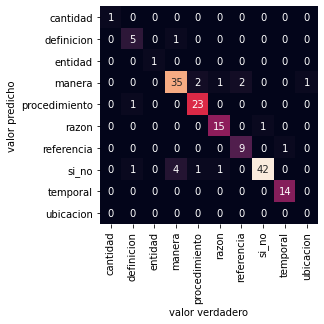

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       0.83      0.71      0.77         7
      entidad       1.00      1.00      1.00         1
       manera       0.85      0.88      0.86        40
procedimiento       0.96      0.88      0.92        26
        razon       0.94      0.88      0.91        17
   referencia       0.90      0.82      0.86        11
        si_no       0.86      0.98      0.91        43
     temporal       1.00      0.93      0.97        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.90       162
    macro avg       0.83      0.81      0.82       162
 weighted avg       0.89      0.90      0.89       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.986
- Accuracy Score - cross-validation: 0.84
- Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.938


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,0.288991,0.011761,0.042230,0.002318,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.861224,0.824490,0.820408,0.823770,0.868852,0.839749,0.020835,1
88,0.291994,0.013799,0.040427,0.001498,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.836735,0.840816,0.820408,0.815574,0.872951,0.837297,0.020204,2
76,0.291078,0.007579,0.040628,0.007655,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.848980,0.816327,0.824490,0.819672,0.868852,0.835664,0.020166,3
89,0.268178,0.005180,0.037225,0.001328,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.848980,0.836735,0.812245,0.799180,0.881148,0.835657,0.028729,4
55,0.218945,0.005422,0.035623,0.000800,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.844898,0.812245,0.808163,0.831967,0.877049,0.834865,0.024953,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


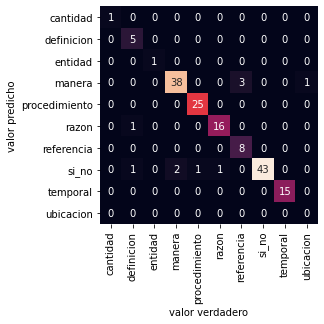

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.95      0.93        40
procedimiento       1.00      0.96      0.98        26
        razon       0.94      0.94      0.94        17
   referencia       1.00      0.73      0.84        11
        si_no       0.90      1.00      0.95        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.94       162
    macro avg       0.87      0.83      0.85       162
 weighted avg       0.94      0.94      0.93       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 6168
Vocabulario: [' 07', ' 07 ', ' 07/', ' 12', ' 12 ', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 27%', ' 3 ', ' 3 a', ' 3 u']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.843
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.914


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,2.054163,0.028587,0.324013,0.005157,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.853061,0.824490,0.844898,0.827869,0.864754,0.843014,0.015163,1
89,1.924077,0.015115,0.307803,0.003443,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.840816,0.824490,0.844898,0.823770,0.860656,0.838926,0.013781,2
86,1.911068,0.068650,0.316809,0.005958,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.844898,0.828571,0.836735,0.827869,0.848361,0.837287,0.008313,3
76,1.971508,0.055946,0.311005,0.003431,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.836735,0.832653,0.832653,0.815574,0.848361,0.833195,0.010523,4
67,1.295261,0.036206,0.266774,0.005752,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.836735,0.787755,0.820408,0.811475,0.852459,0.821766,0.022048,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


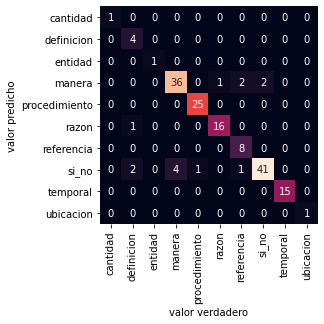

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.57      0.73         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.90      0.89        40
procedimiento       1.00      0.96      0.98        26
        razon       0.94      0.94      0.94        17
   referencia       1.00      0.73      0.84        11
        si_no       0.84      0.95      0.89        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.91       162
    macro avg       0.97      0.91      0.93       162
 weighted avg       0.92      0.91      0.91       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.993
- Accuracy Score - cross-validation: 0.834
- Mejores parametros: {'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=5, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.951


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.463508,0.011998,0.054836,0.002317,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.844898,0.816327,0.836735,0.827869,0.844262,0.834018,0.010784,1
91,0.435289,0.028753,0.051834,0.002041,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.840816,0.828571,0.840816,0.811475,0.840164,0.832369,0.011441,2
79,0.450699,0.014782,0.053636,0.003006,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.836735,0.808163,0.836735,0.831967,0.844262,0.831572,0.012349,3
89,0.552966,0.011118,0.054237,0.000981,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.840816,0.812245,0.828571,0.819672,0.848361,0.829933,0.013252,4
88,0.580585,0.013084,0.063042,0.001096,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.832653,0.816327,0.824490,0.815574,0.840164,0.825841,0.009480,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


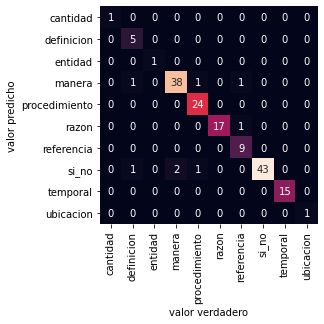

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.93      0.95      0.94        40
procedimiento       1.00      0.92      0.96        26
        razon       0.94      1.00      0.97        17
   referencia       1.00      0.82      0.90        11
        si_no       0.91      1.00      0.96        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.95       162
    macro avg       0.98      0.94      0.96       162
 weighted avg       0.95      0.95      0.95       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.828
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.895


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.527550,0.034591,0.0008,4.000905e-04,10,{'C': 10},0.861224,0.800000,0.787755,0.836066,0.856557,0.828321,0.029623,1
5,0.655835,0.022550,0.0008,4.001621e-04,100,{'C': 100},0.861224,0.808163,0.795918,0.827869,0.844262,0.827487,0.023621,2
3,0.363442,0.015840,0.0008,3.997814e-04,1,{'C': 1},0.848980,0.775510,0.795918,0.807377,0.852459,0.816049,0.030113,3
2,0.269979,0.010272,0.0010,2.611745e-07,0.1,{'C': 0.1},0.738776,0.714286,0.702041,0.717213,0.721311,0.718725,0.011909,4
1,0.221347,0.011345,0.0006,4.898629e-04,0.01,{'C': 0.01},0.477551,0.485714,0.453061,0.475410,0.450820,0.468511,0.013978,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


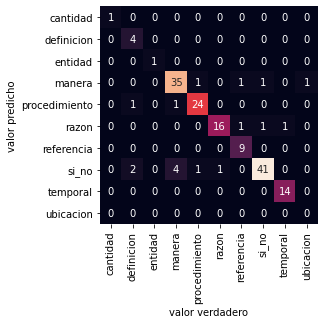

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.57      0.73         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.88      0.89        40
procedimiento       0.92      0.92      0.92        26
        razon       0.84      0.94      0.89        17
   referencia       1.00      0.82      0.90        11
        si_no       0.84      0.95      0.89        43
     temporal       1.00      0.93      0.97        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.90       162
    macro avg       0.85      0.80      0.82       162
 weighted avg       0.90      0.90      0.89       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.839
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.926


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.677050,0.020785,0.001000,2.861023e-07,100,{'C': 100},0.853061,0.816327,0.832653,0.831967,0.860656,0.838933,0.015940,1
4,0.456103,0.014340,0.000800,7.486469e-04,10,{'C': 10},0.844898,0.800000,0.828571,0.811475,0.868852,0.830759,0.024388,2
3,0.247964,0.016003,0.001001,5.917394e-07,1,{'C': 1},0.738776,0.734694,0.759184,0.709016,0.754098,0.739154,0.017623,3
2,0.133689,0.008551,0.000800,3.999954e-04,0.1,{'C': 0.1},0.428571,0.428571,0.428571,0.438525,0.413934,0.427635,0.007860,4
0,0.237958,0.027956,0.000800,4.000189e-04,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


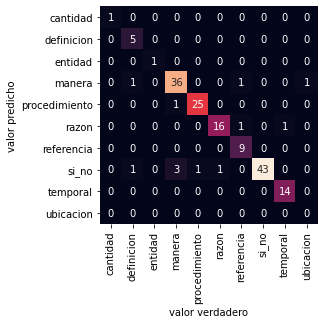

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.92      0.90      0.91        40
procedimiento       0.96      0.96      0.96        26
        razon       0.89      0.94      0.91        17
   referencia       1.00      0.82      0.90        11
        si_no       0.88      1.00      0.93        43
     temporal       1.00      0.93      0.97        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.93       162
    macro avg       0.87      0.83      0.84       162
 weighted avg       0.92      0.93      0.92       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 6168
Vocabulario: [' 07', ' 07 ', ' 07/', ' 12', ' 12 ', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 27%', ' 3 ', ' 3 a', ' 3 u']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.836
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.926


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.660163,0.055750,0.001602,4.901355e-04,100,{'C': 100},0.853061,0.816327,0.832653,0.823770,0.856557,0.836474,0.015877,1
4,1.816004,0.090338,0.002002,4.422006e-07,10,{'C': 10},0.836735,0.787755,0.828571,0.807377,0.836066,0.819301,0.019017,2
3,1.017274,0.055026,0.001801,7.487998e-04,1,{'C': 1},0.722449,0.726531,0.697959,0.696721,0.729508,0.714634,0.014302,3
2,0.494327,0.031011,0.001601,4.899014e-04,0.1,{'C': 0.1},0.412245,0.420408,0.428571,0.426230,0.413934,0.420278,0.006465,4
0,0.868776,0.046886,0.001801,3.997327e-04,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


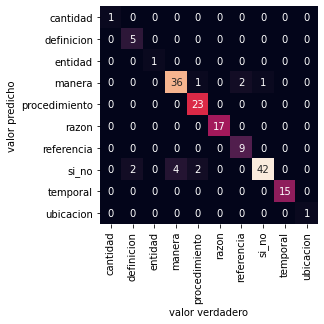

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.90      0.90        40
procedimiento       1.00      0.88      0.94        26
        razon       1.00      1.00      1.00        17
   referencia       1.00      0.82      0.90        11
        si_no       0.84      0.98      0.90        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.93       162
    macro avg       0.97      0.93      0.95       162
 weighted avg       0.93      0.93      0.93       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.822
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.938


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.720140,0.037819,0.001201,0.000400,100,{'C': 100},0.844898,0.800000,0.832653,0.811475,0.819672,0.821740,0.015733,1
4,1.228614,0.020531,0.001001,0.000633,10,{'C': 10},0.828571,0.783673,0.808163,0.807377,0.803279,0.806213,0.014295,2
3,0.712272,0.045771,0.001401,0.000490,1,{'C': 1},0.693878,0.697959,0.677551,0.663934,0.696721,0.686009,0.013254,3
0,0.645627,0.027083,0.001402,0.000490,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,4
1,0.332019,0.031431,0.001402,0.000490,0.01,{'C': 0.01},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


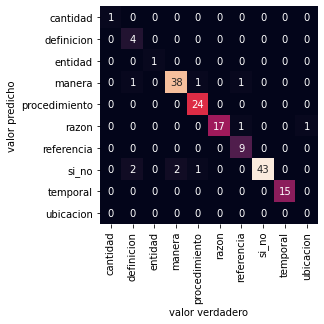

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.57      0.73         7
      entidad       1.00      1.00      1.00         1
       manera       0.93      0.95      0.94        40
procedimiento       1.00      0.92      0.96        26
        razon       0.89      1.00      0.94        17
   referencia       1.00      0.82      0.90        11
        si_no       0.90      1.00      0.95        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.94       162
    macro avg       0.87      0.83      0.84       162
 weighted avg       0.94      0.94      0.93       162


CARGA DE DATASET: DS2 - TRAINING SET Y TESTING SET

TRAINING SET Y TESTING SET: Obtenidos de distintos archivos
TRAINING SET:
LECTURA DEL ARCHIVO: DS2-train_usuario.csv
   IUCA   

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Datos procesados:
que debe cumplir para proceder recategorizacion oficio
cual es diferencia entre unidad explotacion actividad economica
cambio domicilio realiza online
para sacar alguien obra social que debo hacer
hay actividades que excluidas monotributo
...

FIN DE PREPROCESAMIENTO - DS2

DS2 - PREPROCESAMIENTO TESTING SET - TIPO: PROC_STOPWORD_CONFILTRO

Datos a procesar:
¿Cómo se modifica la situación frente al Monotributo en caso de realizar aportes obligatorios a una caja previsional provincial?
Respecto del componente previsional (jubilación y obra social), ¿se puede abonar solo uno de dichos conceptos y excluir del pago el otro?
¿Quiénes se encuentran obligados a emitir comprobantes de forma manual?
¿En qué casos se produce la baja automática en el Monotributo?
Pasos para adherirse mediante el portal de Monotributo.
...
Datos procesados:
como modifica situacion frente monotributo caso realizar aportes obligatorios caja previsional provincial
respecto componente previsional jub

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.834
- Mejores parametros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.895


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
76,0.248965,0.011024,0.030220,0.002137,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.832653,0.820408,0.824490,0.840164,0.852459,0.834035,0.011452,1
64,0.219946,0.015128,0.029219,0.002715,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.844898,0.816327,0.824490,0.831967,0.848361,0.833208,0.012073,2
88,0.241760,0.014075,0.029820,0.001941,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.832653,0.820408,0.824490,0.831967,0.852459,0.832395,0.011036,3
86,0.146697,0.008552,0.023015,0.003164,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.840816,0.812245,0.812245,0.811475,0.852459,0.825848,0.017372,4
52,0.232754,0.007945,0.030621,0.002246,2,0.1,rbf,"{'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}",0.832653,0.804082,0.804082,0.827869,0.827869,0.819311,0.012557,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


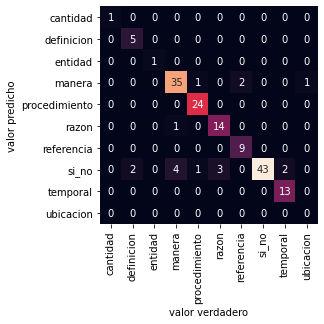

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.88      0.89        40
procedimiento       1.00      0.92      0.96        26
        razon       0.93      0.82      0.87        17
   referencia       1.00      0.82      0.90        11
        si_no       0.78      1.00      0.88        43
     temporal       1.00      0.87      0.93        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.90       162
    macro avg       0.86      0.80      0.83       162
 weighted avg       0.90      0.90      0.89       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.828
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.932


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,0.195529,0.004633,0.028619,0.001856,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.812245,0.836735,0.828571,0.803279,0.860656,0.828297,0.020010,1
89,0.184722,0.002061,0.025417,0.002334,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.816327,0.828571,0.820408,0.811475,0.860656,0.827487,0.017506,2
86,0.188125,0.014707,0.027618,0.002579,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.828571,0.812245,0.836735,0.811475,0.840164,0.825838,0.012021,3
55,0.143095,0.004651,0.024016,0.002610,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.836735,0.795918,0.820408,0.823770,0.844262,0.824219,0.016577,4
76,0.202334,0.009070,0.028619,0.002418,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.836735,0.804082,0.828571,0.811475,0.836066,0.823386,0.013269,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


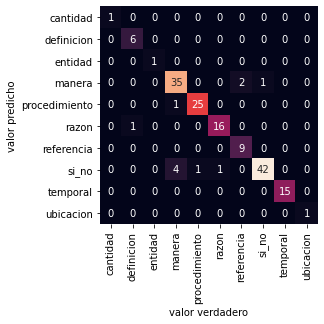

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.86      0.92         7
      entidad       1.00      1.00      1.00         1
       manera       0.92      0.88      0.90        40
procedimiento       0.96      0.96      0.96        26
        razon       0.94      0.94      0.94        17
   referencia       1.00      0.82      0.90        11
        si_no       0.88      0.98      0.92        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.93       162
    macro avg       0.97      0.94      0.95       162
 weighted avg       0.93      0.93      0.93       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.836
- Mejores parametros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.926


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,1.451993,0.051350,0.218980,0.017322,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.844898,0.820408,0.828571,0.831967,0.856557,0.836480,0.012769,1
76,1.505594,0.083510,0.247359,0.018142,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.848980,0.824490,0.836735,0.815574,0.852459,0.835647,0.014064,2
89,1.386386,0.065564,0.203796,0.010261,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.853061,0.812245,0.828571,0.831967,0.844262,0.834021,0.013968,3
86,1.367991,0.073291,0.219195,0.009898,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.844898,0.828571,0.828571,0.807377,0.856557,0.833195,0.016686,4
67,0.998141,0.011437,0.209828,0.015983,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.812245,0.828571,0.816327,0.823770,0.860656,0.828314,0.017138,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


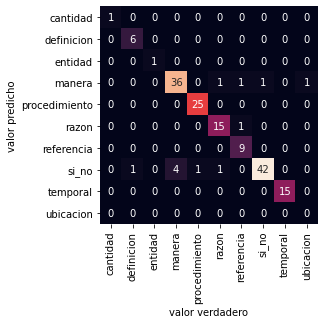

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.86      0.92         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.90      0.90        40
procedimiento       1.00      0.96      0.98        26
        razon       0.94      0.88      0.91        17
   referencia       1.00      0.82      0.90        11
        si_no       0.86      0.98      0.91        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.93       162
    macro avg       0.87      0.84      0.85       162
 weighted avg       0.92      0.93      0.92       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.995
- Accuracy Score - cross-validation: 0.834
- Mejores parametros: {'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=5, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.951


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.352555,0.006955,0.040625,0.007657,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.848980,0.832653,0.832653,0.827869,0.827869,0.834005,0.007787,1
55,0.373949,0.001770,0.039042,0.005102,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.853061,0.824490,0.836735,0.827869,0.823770,0.833185,0.010956,2
91,0.310046,0.027224,0.037713,0.007492,100,1,sigmoid,"{'C': 100, 'gamma': 1, 'kernel': 'sigmoid'}",0.836735,0.824490,0.828571,0.823770,0.836066,0.829926,0.005538,3
89,0.401380,0.021776,0.034591,0.006158,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.836735,0.824490,0.840816,0.823770,0.819672,0.829097,0.008174,4
79,0.338375,0.034223,0.037502,0.007655,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.840816,0.828571,0.832653,0.811475,0.827869,0.828277,0.009581,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


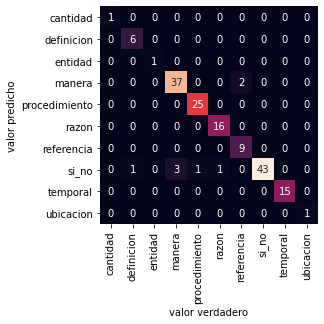

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.86      0.92         7
      entidad       1.00      1.00      1.00         1
       manera       0.95      0.93      0.94        40
procedimiento       1.00      0.96      0.98        26
        razon       1.00      0.94      0.97        17
   referencia       1.00      0.82      0.90        11
        si_no       0.88      1.00      0.93        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.95       162
    macro avg       0.98      0.95      0.96       162
 weighted avg       0.95      0.95      0.95       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.999
- Accuracy Score - cross-validation: 0.828
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.864


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.407353,0.016401,0.000000,0.000000,10,{'C': 10},0.853061,0.804082,0.791837,0.836066,0.856557,0.828321,0.026031,1
5,0.563181,0.009891,0.003125,0.006251,100,{'C': 100},0.848980,0.804082,0.787755,0.827869,0.852459,0.824229,0.025136,2
3,0.253363,0.006703,0.000000,0.000000,1,{'C': 1},0.832653,0.771429,0.795918,0.807377,0.844262,0.810328,0.025998,3
2,0.172103,0.013985,0.000000,0.000000,0.1,{'C': 0.1},0.755102,0.685714,0.710204,0.688525,0.729508,0.713811,0.026051,4
1,0.168974,0.011759,0.000000,0.000000,0.01,{'C': 0.01},0.473469,0.477551,0.428571,0.467213,0.434426,0.456246,0.020556,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


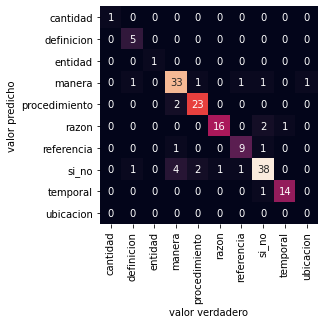

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.87      0.82      0.85        40
procedimiento       0.92      0.88      0.90        26
        razon       0.84      0.94      0.89        17
   referencia       0.82      0.82      0.82        11
        si_no       0.81      0.88      0.84        43
     temporal       0.93      0.93      0.93        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.86       162
    macro avg       0.82      0.80      0.81       162
 weighted avg       0.86      0.86      0.86       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.834
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.907


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.660058,0.028688,0.003125,0.00625,100,{'C': 100},0.828571,0.820408,0.820408,0.831967,0.868852,0.834041,0.017988,1
4,0.441516,0.006915,0.000000,0.00000,10,{'C': 10},0.824490,0.791837,0.816327,0.807377,0.856557,0.819317,0.021542,2
3,0.247317,0.015408,0.000000,0.00000,1,{'C': 1},0.759184,0.718367,0.751020,0.709016,0.762295,0.739977,0.021975,3
2,0.128131,0.006250,0.000000,0.00000,0.1,{'C': 0.1},0.432653,0.420408,0.432653,0.446721,0.422131,0.430913,0.009417,4
0,0.219605,0.022993,0.003125,0.00625,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


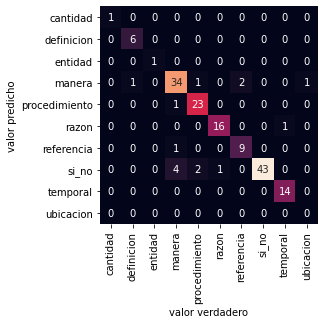

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.86      0.92         7
      entidad       1.00      1.00      1.00         1
       manera       0.87      0.85      0.86        40
procedimiento       0.96      0.88      0.92        26
        razon       0.94      0.94      0.94        17
   referencia       0.90      0.82      0.86        11
        si_no       0.86      1.00      0.92        43
     temporal       1.00      0.93      0.97        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.91       162
    macro avg       0.85      0.83      0.84       162
 weighted avg       0.91      0.91      0.90       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vocabulario: [' 07', ' 07 ', ' 07/', ' 12', ' 12 ', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 27%', ' 3 ', ' 3 a', ' 3 u']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.847
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.914


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.358285,0.082372,0.00000,0.000000,100,{'C': 100},0.853061,0.848980,0.857143,0.819672,0.856557,0.847083,0.014012,1
4,1.683147,0.118523,0.00645,0.007500,10,{'C': 10},0.824490,0.820408,0.832653,0.807377,0.827869,0.822559,0.008590,2
3,0.846289,0.045238,0.00060,0.001200,1,{'C': 1},0.738776,0.726531,0.714286,0.700820,0.766393,0.729361,0.022405,3
2,0.447852,0.026933,0.00000,0.000000,0.1,{'C': 0.1},0.416327,0.416327,0.436735,0.418033,0.409836,0.419451,0.009085,4
0,0.782168,0.039349,0.00625,0.007654,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


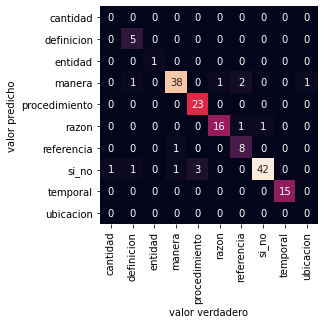

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.95      0.92        40
procedimiento       1.00      0.88      0.94        26
        razon       0.89      0.94      0.91        17
   referencia       0.89      0.73      0.80        11
        si_no       0.88      0.98      0.92        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.91       162
    macro avg       0.75      0.72      0.73       162
 weighted avg       0.91      0.91      0.91       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 1.0
- Accuracy Score - cross-validation: 0.826
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.938


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.394106,0.068261,0.000000,0.000000,100,{'C': 100},0.840816,0.800000,0.836735,0.815574,0.836066,0.825838,0.015625,1
4,1.021320,0.036783,0.003125,0.006249,10,{'C': 10},0.808163,0.779592,0.812245,0.795082,0.811475,0.801311,0.012493,2
3,0.581752,0.041959,0.000000,0.000000,1,{'C': 1},0.702041,0.693878,0.706122,0.663934,0.684426,0.690080,0.015036,3
2,0.316931,0.029228,0.000000,0.000000,0.1,{'C': 0.1},0.404082,0.408163,0.404082,0.405738,0.409836,0.406380,0.002285,4
0,0.535054,0.042755,0.000000,0.000000,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


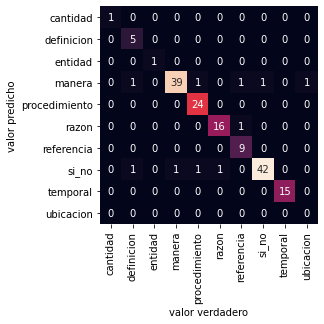

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       1.00      1.00      1.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.89      0.97      0.93        40
procedimiento       1.00      0.92      0.96        26
        razon       0.94      0.94      0.94        17
   referencia       1.00      0.82      0.90        11
        si_no       0.91      0.98      0.94        43
     temporal       1.00      1.00      1.00        15
    ubicacion       0.00      0.00      0.00         1

     accuracy                           0.94       162
    macro avg       0.87      0.83      0.85       162
 weighted avg       0.94      0.94      0.93       162


CARGA DE DATASET: DS2 - TRAINING SET Y TESTING SET

TRAINING SET Y TESTING SET: Obtenidos de distintos archivos
TRAINING SET:
LECTURA DEL ARCHIVO: DS2-train_usuario.csv
   IUCA   

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Datos procesados:
debe cumplir proceder recategorizacion oficio
diferencia unidad explotacion actividad economica
cambio domicilio realiza online
sacar alguien obra social debo hacer
actividades excluidas monotributo
...

FIN DE PREPROCESAMIENTO - DS2

DS2 - PREPROCESAMIENTO TESTING SET - TIPO: PROC_STOPWORD_SINFILTRO

Datos a procesar:
¿Cómo se modifica la situación frente al Monotributo en caso de realizar aportes obligatorios a una caja previsional provincial?
Respecto del componente previsional (jubilación y obra social), ¿se puede abonar solo uno de dichos conceptos y excluir del pago el otro?
¿Quiénes se encuentran obligados a emitir comprobantes de forma manual?
¿En qué casos se produce la baja automática en el Monotributo?
Pasos para adherirse mediante el portal de Monotributo.
...
Datos procesados:
modifica situacion frente monotributo caso realizar aportes obligatorios caja previsional provincial
respecto componente previsional jubilacion obra social puede abonar solo dichos 

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.975
- Accuracy Score - cross-validation: 0.722
- Mejores parametros: {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=5, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.833


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
64,0.206681,0.020989,0.028127,0.006250,5,0.1,rbf,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.742857,0.714286,0.718367,0.692623,0.741803,0.721987,0.018777,1
76,0.203354,0.029534,0.018752,0.006250,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.718367,0.718367,0.706122,0.704918,0.733607,0.716276,0.010404,2
88,0.215853,0.023145,0.021876,0.007655,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.726531,0.702041,0.677551,0.688525,0.737705,0.706470,0.022610,3
87,0.181690,0.007584,0.025001,0.007655,100,0.01,sigmoid,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.706122,0.693878,0.685714,0.688525,0.725410,0.699930,0.014535,4
86,0.171884,0.013976,0.018751,0.006250,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.714286,0.689796,0.677551,0.692623,0.721311,0.699113,0.016229,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


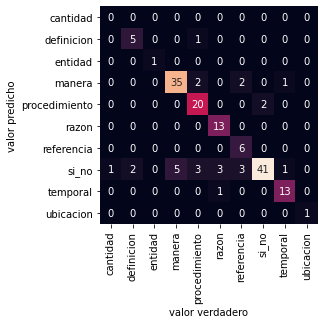

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.83      0.71      0.77         7
      entidad       1.00      1.00      1.00         1
       manera       0.88      0.88      0.88        40
procedimiento       0.91      0.77      0.83        26
        razon       1.00      0.76      0.87        17
   referencia       1.00      0.55      0.71        11
        si_no       0.69      0.95      0.80        43
     temporal       0.93      0.87      0.90        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.83       162
    macro avg       0.82      0.75      0.78       162
 weighted avg       0.85      0.83      0.83       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.941
- Accuracy Score - cross-validation: 0.723
- Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=100, gamma=0.01)

- Accuracy Score sobre TESTING SET: 0.84


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,0.190850,0.006157,0.028126,0.006250,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.714286,0.693878,0.726531,0.713115,0.766393,0.722840,0.024154,1
55,0.153349,0.005817,0.025001,0.007655,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.726531,0.677551,0.718367,0.704918,0.766393,0.718752,0.029049,2
76,0.206689,0.018522,0.028144,0.006258,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.718367,0.697959,0.718367,0.704918,0.754098,0.718742,0.019357,3
67,0.137719,0.011758,0.025002,0.007654,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.706122,0.697959,0.702041,0.684426,0.754098,0.708929,0.023733,4
88,0.240388,0.010077,0.023554,0.006992,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.685714,0.693878,0.689796,0.713115,0.737705,0.704041,0.019275,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


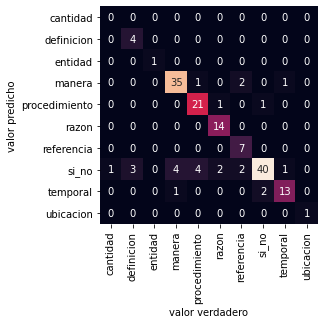

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       1.00      0.57      0.73         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.88      0.89        40
procedimiento       0.91      0.81      0.86        26
        razon       1.00      0.82      0.90        17
   referencia       1.00      0.64      0.78        11
        si_no       0.70      0.93      0.80        43
     temporal       0.81      0.87      0.84        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.84       162
    macro avg       0.83      0.75      0.78       162
 weighted avg       0.86      0.84      0.84       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tamaño de Vocabulario: 5684
Vocabulario: [' 07', ' 07 ', ' 07/', ' 12', ' 12 ', ' 20', ' 200', ' 25', ' 253', ' 27', ' 27 ', ' 27%', ' 3 ', ' 3 a', ' 30']
>>Representación 3_4G_CHAR: OK!

2. GRIDSEARCH con CV (CV=5) sobre: TRAINING SET


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.947
- Accuracy Score - cross-validation: 0.715
- Mejores parametros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- Mejor Modelo encontrado: SVC(C=10, gamma=0.1)

- Accuracy Score sobre TESTING SET: 0.852


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
76,1.283024,0.043479,0.216091,0.011536,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.697959,0.689796,0.718367,0.717213,0.750000,0.714667,0.020815,1
86,1.250485,0.050324,0.206482,0.015271,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.697959,0.689796,0.718367,0.721311,0.741803,0.713847,0.018377,2
88,1.436630,0.052477,0.206699,0.015681,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.673469,0.685714,0.702041,0.717213,0.733607,0.702409,0.021489,3
89,1.309797,0.054775,0.195567,0.023513,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.681633,0.689796,0.693878,0.700820,0.741803,0.701586,0.021046,4
55,0.986124,0.031864,0.180803,0.006951,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.681633,0.677551,0.706122,0.696721,0.737705,0.699946,0.021500,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


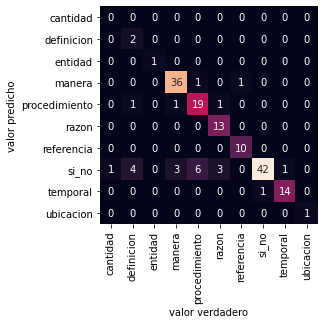

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       1.00      0.29      0.44         7
      entidad       1.00      1.00      1.00         1
       manera       0.95      0.90      0.92        40
procedimiento       0.86      0.73      0.79        26
        razon       1.00      0.76      0.87        17
   referencia       1.00      0.91      0.95        11
        si_no       0.70      0.98      0.82        43
     temporal       0.93      0.93      0.93        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.85       162
    macro avg       0.84      0.75      0.77       162
 weighted avg       0.87      0.85      0.85       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.977
- Accuracy Score - cross-validation: 0.724
- Mejores parametros: {'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}
- Mejor Modelo encontrado: SVC(C=5, gamma=1, kernel='sigmoid')

- Accuracy Score sobre TESTING SET: 0.846


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.265703,0.012583,0.026864,0.002317,5,1,sigmoid,"{'C': 5, 'gamma': 1, 'kernel': 'sigmoid'}",0.710204,0.722449,0.734694,0.713115,0.737705,0.723633,0.011070,1
79,0.268960,0.031394,0.025632,0.005866,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.710204,0.710204,0.718367,0.704918,0.725410,0.713821,0.007217,2
55,0.302586,0.010801,0.027234,0.005888,2,1,sigmoid,"{'C': 2, 'gamma': 1, 'kernel': 'sigmoid'}",0.710204,0.710204,0.710204,0.717213,0.709016,0.711368,0.002958,3
86,0.301261,0.019601,0.031250,0.000002,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.693878,0.730612,0.685714,0.725410,0.704918,0.708106,0.017435,4
89,0.291882,0.006168,0.024149,0.004418,100,0.1,sigmoid,"{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}",0.702041,0.714286,0.693878,0.709016,0.721311,0.708106,0.009515,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


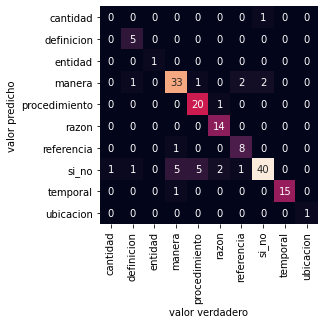

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       1.00      0.71      0.83         7
      entidad       1.00      1.00      1.00         1
       manera       0.85      0.82      0.84        40
procedimiento       0.95      0.77      0.85        26
        razon       1.00      0.82      0.90        17
   referencia       0.89      0.73      0.80        11
        si_no       0.73      0.93      0.82        43
     temporal       0.94      1.00      0.97        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.85       162
    macro avg       0.84      0.78      0.80       162
 weighted avg       0.86      0.85      0.85       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.984
- Accuracy Score - cross-validation: 0.711
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.858


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.395376,0.016618,0.0004,0.00049,10,{'C': 10},0.718367,0.685714,0.693878,0.717213,0.737705,0.710575,0.018642,1
3,0.211315,0.002741,0.0004,0.00049,1,{'C': 1},0.706122,0.685714,0.702041,0.696721,0.741803,0.706480,0.018942,2
5,0.718741,0.038419,0.0000,0.00000,100,{'C': 100},0.702041,0.689796,0.681633,0.676230,0.704918,0.690923,0.011162,3
2,0.131488,0.009484,0.0008,0.00040,0.1,{'C': 0.1},0.624490,0.620408,0.600000,0.598361,0.618852,0.612422,0.010980,4
1,0.109886,0.009632,0.0000,0.00000,0.01,{'C': 0.01},0.408163,0.420408,0.404082,0.409836,0.405738,0.409645,0.005732,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


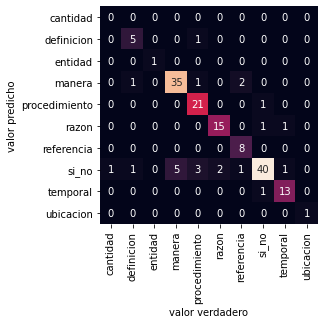

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.83      0.71      0.77         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.88      0.89        40
procedimiento       0.95      0.81      0.88        26
        razon       0.88      0.88      0.88        17
   referencia       1.00      0.73      0.84        11
        si_no       0.74      0.93      0.82        43
     temporal       0.93      0.87      0.90        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.86       162
    macro avg       0.82      0.78      0.80       162
 weighted avg       0.87      0.86      0.86       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.969
- Accuracy Score - cross-validation: 0.72
- Mejores parametros: {'C': 10}
- Mejor Modelo encontrado: LogisticRegression(C=10, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.846


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.441037,0.010861,0.003525,0.006067,10,{'C': 10},0.714286,0.677551,0.718367,0.725410,0.766393,0.720401,0.028348,1
5,0.736520,0.022268,0.000400,0.000490,100,{'C': 100},0.706122,0.685714,0.714286,0.704918,0.737705,0.709749,0.016830,2
3,0.216779,0.006513,0.000600,0.000490,1,{'C': 1},0.665306,0.669388,0.620408,0.639344,0.680328,0.654955,0.021893,3
2,0.116340,0.004603,0.000600,0.000490,0.1,{'C': 0.1},0.404082,0.412245,0.408163,0.422131,0.405738,0.410472,0.006445,4
0,0.204374,0.011076,0.000400,0.000490,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


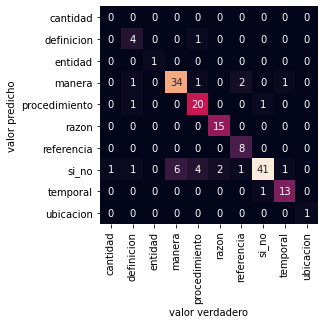

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.80      0.57      0.67         7
      entidad       1.00      1.00      1.00         1
       manera       0.87      0.85      0.86        40
procedimiento       0.91      0.77      0.83        26
        razon       1.00      0.88      0.94        17
   referencia       1.00      0.73      0.84        11
        si_no       0.72      0.95      0.82        43
     temporal       0.93      0.87      0.90        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.85       162
    macro avg       0.82      0.76      0.79       162
 weighted avg       0.86      0.85      0.84       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.989
- Accuracy Score - cross-validation: 0.718
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.827


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.529695,0.092065,0.000801,0.000981,100,{'C': 100},0.697959,0.693878,0.722449,0.729508,0.745902,0.717939,0.019567,1
4,1.534871,0.064586,0.000400,0.000800,10,{'C': 10},0.677551,0.697959,0.714286,0.717213,0.729508,0.707303,0.017958,2
3,0.763611,0.014252,0.000000,0.000000,1,{'C': 1},0.636735,0.665306,0.616327,0.622951,0.668033,0.641870,0.021310,3
2,0.397372,0.018964,0.001401,0.000801,0.1,{'C': 0.1},0.408163,0.420408,0.420408,0.422131,0.409836,0.416189,0.005928,4
0,0.665313,0.097559,0.000611,0.000820,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,5


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


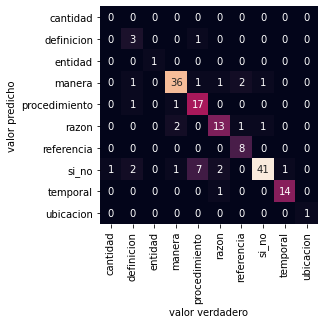

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.75      0.43      0.55         7
      entidad       1.00      1.00      1.00         1
       manera       0.86      0.90      0.88        40
procedimiento       0.89      0.65      0.76        26
        razon       0.76      0.76      0.76        17
   referencia       1.00      0.73      0.84        11
        si_no       0.75      0.95      0.84        43
     temporal       0.93      0.93      0.93        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.83       162
    macro avg       0.79      0.74      0.76       162
 weighted avg       0.83      0.83      0.82       162


---------------------------------------------------------------------------------------------------------
REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJO

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


>>RESULTADOS OBTENIDOS
- Accuracy Score sobre TRAINING SET: 0.989
- Accuracy Score - cross-validation: 0.706
- Mejores parametros: {'C': 100}
- Mejor Modelo encontrado: LogisticRegression(C=100, max_iter=1000)

- Accuracy Score sobre TESTING SET: 0.858


- GridSearchCV - REPORTE:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.410770,0.041759,0.004126,0.005797,100,{'C': 100},0.706122,0.706122,0.685714,0.700820,0.733607,0.706477,0.015488,1
4,1.003822,0.093729,0.000401,0.000491,10,{'C': 10},0.706122,0.702041,0.673469,0.692623,0.709016,0.696654,0.012847,2
3,0.530357,0.024837,0.001201,0.000400,1,{'C': 1},0.591837,0.608163,0.583673,0.598361,0.602459,0.596899,0.008491,3
0,0.476252,0.054919,0.000400,0.000490,0.001,{'C': 0.001},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,4
1,0.212691,0.010340,0.000601,0.000491,0.01,{'C': 0.01},0.404082,0.408163,0.404082,0.405738,0.405738,0.405560,0.001497,4


MATRIZ DE CONFUSIÓN PARA EL MEJOR MODELO


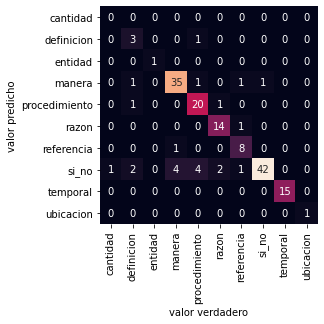

REPORTES DE CLASIFICACIÓN PARA EL MEJOR MODELO
               precision    recall  f1-score   support

     cantidad       0.00      0.00      0.00         1
   definicion       0.75      0.43      0.55         7
      entidad       1.00      1.00      1.00         1
       manera       0.90      0.88      0.89        40
procedimiento       0.91      0.77      0.83        26
        razon       0.93      0.82      0.87        17
   referencia       0.89      0.73      0.80        11
        si_no       0.75      0.98      0.85        43
     temporal       1.00      1.00      1.00        15
    ubicacion       1.00      1.00      1.00         1

     accuracy                           0.86       162
    macro avg       0.81      0.76      0.78       162
 weighted avg       0.86      0.86      0.85       162


FIN DE EXPERIMENTO SOBRE DATASET:  DS2
>>Resultados ejecución en archivo:  Resultados_2DS_Principal_procTest.csv
>>Resultados Preguntas Mal Clasificadas en:  Resultados_2DS_PregMa

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#--------------------------------------------------------------------------------
# PROGRAMA PRINCIPAL
#--------------------------------------------------------------------------------
import time 
print("INICIO DE PROGRAMA")
start_time = time.time()

#--------------------------------------------------------------------------------
# Iteración sobre cada dataset: "DS_Select" en Configuraciones para la Ejecución
#--------------------------------------------------------------------------------

for ds in DS_Select.items():  #DATASETS - Ver "DS_Select"
    if(ds[1]==True): 
        dsName = ds[0]
        print('\n=========================================================================================================')
        print("INICIO EXPERIMENTO SOBRE DATASET: ", dsName)
        print('=========================================================================================================')
        ds_obj = dataset(dsName) #Crear objeto dataset
        
        #----------------------------------------------------------------------------------------------------
        # Iteración sobre cada Tipo de Preprocesamiento: PREPROC_Select en Configuraciones para la Ejecución
        #----------------------------------------------------------------------------------------------------
        for p in PREPROC_Select.items():   #PREPROCESAMIENTOS - Ver "PREPROC_Select" 
            if p[1]==True:
                tipoPreproc = p[0]    
                if(ds[0]=="DS1"):          #generar_dataset(training-set, testing-set, preprocesamiento) 
                    ds_obj.generar_dataset(DS1_PATH, None, tipoPreproc) #testing no definido => split dataset
                if(ds[0]=="DS2"): 
                    ds_obj.generar_dataset(DS2_PATH, TEST_PATH, tipoPreproc) #testing definido
                
                #----------------------------------------------------------------------------------------------------
                # Iteración sobre cada Tipo de Modelo: MOD_Select en Configuraciones para la Ejecución
                #----------------------------------------------------------------------------------------------------
                for m in MOD_Select.items():          #MODELOS - Ver "MOD_Select"
                    if(m[1]==True):
                        tipoMod = m[0]
                        
                        #----------------------------------------------------------------------------------------------------
                        # Iteración sobre cada Tipo de Representación: REPSEN_Select en Configuraciones para la Ejecución
                        #----------------------------------------------------------------------------------------------------
                        for rep in REPSEN_Select.items():          #REPRESENTACIONES - Ver "REPSEN_Select" 
                            if(rep[1]==True):
                                tipoRep = rep[0]
                                print('\n---------------------------------------------------------------------------------------------------------')
                                print('REPRESENTACION - BÚSQUEDA MEJOR MODELO (GRIDSEARCH) - EVALUACIÓN DEL MEJOR MODELO')
                                print('DATASET: {} - PREPROCESAMIENTO: {} - MODELO: {} - REPRESENTACIÓN: {}'.format(dsName, tipoPreproc, tipoMod, tipoRep))
                                print('---------------------------------------------------------------------------------------------------------')
                                experimento(ds_obj, tipoPreproc, tipoMod, tipoRep)

        print('\n=========================================================================================================')
        print("FIN DE EXPERIMENTO SOBRE DATASET: ", ds[0])
        print('=========================================================================================================')

#----------------------------------------------------------------------------------------------------
# Almacenamiento de Resultados Finales
#----------------------------------------------------------------------------------------------------
if PRINT_RES:
    DF_RESULTADOS.to_csv(FILENAME_RES, index=False)
    print(">>Resultados ejecución en archivo: ", FILENAME_RES)    
if PRINT_MAL_CLF:
    DF_MAL_CLF.to_csv(FILENAME_RES_CLF, index=False)
    print(">>Resultados Preguntas Mal Clasificadas en: ", FILENAME_RES_CLF)
seg = time.time() - start_time
min = int(seg/60)
seg = int(seg % 60)
print('FIN DE PROGRAMA - {}min - {}seg'.format(min,seg))

***>>FIN DE EXPERIMENTO***